<h1>Análise e Correlações do Preço do Frete na Importação</h1>
<hr>

## Google Colab

In [178]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Bibliotecas

In [179]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches

import re

## Coleta, Processamento e Tratamento dos dados
---


### Dados das Importações Brasileiras
Link: [Ministério da Economia](https://balanca.economia.gov.br/balanca/bd/comexstat-bd/ncm/IMP_COMPLETA.zip)

In [180]:
# Coletando os dados
df_importacao = pd.read_csv("/content/drive/Shareddrives/TCC Daniel dados/IMP_COMPLETA.csv",sep=';')
#df_importacao = pd.read_csv('../datasets/IMP_COMPLETA.csv',sep=';')


In [181]:
# Informações de linhas e colunas do dataset df_urf
df_importacao.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36389808 entries, 0 to 36389807
Data columns (total 13 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   CO_ANO      int64 
 1   CO_MES      int64 
 2   CO_NCM      int64 
 3   CO_UNID     int64 
 4   CO_PAIS     int64 
 5   SG_UF_NCM   object
 6   CO_VIA      int64 
 7   CO_URF      int64 
 8   QT_ESTAT    int64 
 9   KG_LIQUIDO  int64 
 10  VL_FOB      int64 
 11  VL_FRETE    int64 
 12  VL_SEGURO   int64 
dtypes: int64(12), object(1)
memory usage: 3.5+ GB


In [182]:
# Filtrando dados dos últimos 10 anos (2012 - 2022)
df_importacao = df_importacao[df_importacao.CO_ANO >= 2012]

# Filtrando as 20 NCM mais importadas em valor FOB
df = df_importacao.groupby(['CO_NCM']).sum().sort_values(by=['VL_FOB'],ascending=False)
fob_total = df.VL_FOB.sum()
df = df.iloc[:20,:][['VL_FOB']]
df.reset_index(inplace=True)
df_importacao = df_importacao[df_importacao.CO_NCM.isin(df.CO_NCM)]

In [183]:
# Percentual que essas NCM representam no valor FOB
maiores_ncm = df.iloc[:20,:]
fob_maiores_ncm = maiores_ncm.VL_FOB.sum()
perc_ncm = fob_maiores_ncm/fob_total
print(f'O percentual que essas NCM representam no valor FOB é de {perc_ncm:.1%}')

O percentual que essas NCM representam no valor FOB é de 25.5%


In [184]:
# Informações de linhas e colunas do dataset df_importacao
df_importacao.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117814 entries, 17700319 to 36389722
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   CO_ANO      117814 non-null  int64 
 1   CO_MES      117814 non-null  int64 
 2   CO_NCM      117814 non-null  int64 
 3   CO_UNID     117814 non-null  int64 
 4   CO_PAIS     117814 non-null  int64 
 5   SG_UF_NCM   117814 non-null  object
 6   CO_VIA      117814 non-null  int64 
 7   CO_URF      117814 non-null  int64 
 8   QT_ESTAT    117814 non-null  int64 
 9   KG_LIQUIDO  117814 non-null  int64 
 10  VL_FOB      117814 non-null  int64 
 11  VL_FRETE    117814 non-null  int64 
 12  VL_SEGURO   117814 non-null  int64 
dtypes: int64(12), object(1)
memory usage: 12.6+ MB


In [185]:
# Visualização do cabeçalho do dataset df_importacao
df_importacao.head()

,CO_ANO,CO_MES,CO_NCM,CO_UNID,CO_PAIS,SG_UF_NCM,CO_VIA,CO_URF,QT_ESTAT,KG_LIQUIDO,VL_FOB,VL_FRETE,VL_SEGURO
17700319,2012,6,85299020,10,351,SP,4,817700,35,35,3252,538,3
17700372,2012,2,31042090,10,149,GO,1,817800,6900000,6900000,3656925,207000,6769
17700388,2012,8,85299020,10,23,SP,1,817800,0,0,167,0,0
17700566,2012,12,84119100,10,149,RJ,4,817700,511,511,1280002,5618,0
17700804,2012,11,84119100,10,249,MG,4,817700,200,200,568191,2602,0


### Tabelas auxiliares
---
Link: [Tabela Códigos](https://balanca.economia.gov.br/balanca/bd/tabelas/TABELAS_AUXILIARES.xlsx)

Indice Excel usado
* 1 (NO_NCM_POR): Descrição NCM
* 10 (CO_PAIS): País de origem do produto
* 14 (CO_VIA): Meio de transporte da mercadoria
* 15 (CO_URF): Local de chegada no Brasil da mercadoria


In [186]:
# Coletando os dados

url = "https://github.com/Migliorin/Comex_Data_Analysis/blob/main/datasets/TABELAS_AUXILIARES.xlsx?raw=true"
xl_file = pd.ExcelFile(url)

#xl_file = pd.ExcelFile('../datasets/TABELAS_AUXILIARES.xlsx')
df_ncm = xl_file.parse('1')
df_pais = xl_file.parse('10')
df_via = xl_file.parse('14')
df_urf = xl_file.parse('15')

In [187]:
# Informações de linhas e colunas do dataset df_ncm
df_ncm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13164 entries, 0 to 13163
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CO_NCM         13164 non-null  int64 
 1   NO_NCM_POR     13164 non-null  object
 2   CO_SH6         13164 non-null  int64 
 3   NO_SH6_POR     13164 non-null  object
 4   NO_SH6_ESP     13164 non-null  object
 5   NO_SH6_ING     13164 non-null  object
 6   CO_SH4         13164 non-null  int64 
 7   NO_SH4_POR     13164 non-null  object
 8   NO_SH4_ESP     13164 non-null  object
 9   NO_SH4_ING     13164 non-null  object
 10  CO_SH2         13164 non-null  int64 
 11  NO_SH2_POR     13164 non-null  object
 12  NO_SH2_ESP     13164 non-null  object
 13  NO_SH2_ING     13164 non-null  object
 14  CO_NCM_SECROM  13164 non-null  object
 15  NO_SEC_POR     13164 non-null  object
 16  NO_SEC_ESP     13164 non-null  object
 17  NO_SEC_ING     13164 non-null  object
dtypes: int64(4), object(14)
me

In [188]:
# Informações de linhas e colunas do dataset df_pais
df_pais.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 281 entries, 0 to 280
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CO_PAIS        281 non-null    int64 
 1   CO_PAIS_ISON3  281 non-null    int64 
 2   CO_PAIS_ISOA3  281 non-null    object
 3   NO_PAIS        281 non-null    object
 4   NO_PAIS_ING    281 non-null    object
 5   NO_PAIS_ESP    281 non-null    object
dtypes: int64(2), object(4)
memory usage: 13.3+ KB


In [189]:
# Informações de linhas e colunas do dataset df_via
df_via.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   CO_VIA  17 non-null     int64 
 1   NO_VIA  17 non-null     object
dtypes: int64(1), object(1)
memory usage: 400.0+ bytes


In [190]:
# Informações de linhas e colunas do dataset df_urf
df_urf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276 entries, 0 to 275
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   CO_URF  276 non-null    int64 
 1   NO_URF  276 non-null    object
dtypes: int64(1), object(1)
memory usage: 4.4+ KB


### Substituição código
---
Para melhor análise e entedimento, será usado a tabela de códigos para substituir os códigos dentro da base bruta. Como as colunas de alguns códigos serão traduzidas, então serão retirados as seguintes colunas:

* CO_NCM
* CO_PAIS
* CO_VIA
* CO_URF

In [191]:
# Unindo os datasets auxiliares com o df_importacao 
df_importacao = df_importacao.merge(df_ncm[['CO_NCM','NO_NCM_POR']],on='CO_NCM')
df_importacao = df_importacao.merge(df_pais[['CO_PAIS','NO_PAIS']],on='CO_PAIS')
df_importacao = df_importacao.merge(df_urf[['CO_URF','NO_URF']],on='CO_URF')
df_importacao = df_importacao.merge(df_via[['CO_VIA','NO_VIA']],on='CO_VIA')

# Criando a coluna NCM, concatenando o código e o nome da NCM 
df_importacao["NCM"] = df_importacao["CO_NCM"].map(str) + " - " + df_importacao["NO_NCM_POR"]

# Apagando as colunas dos códigos que foram utilizadas na união e o nome da NCM
df_importacao.drop(['CO_NCM','CO_PAIS','CO_URF','CO_VIA', 'NO_NCM_POR'],axis=1,inplace=True)

# Reordenando as colunas para melhor visualização
df_importacao = df_importacao[['CO_ANO','CO_MES','NCM','CO_UNID','NO_PAIS','SG_UF_NCM','NO_VIA','NO_URF','QT_ESTAT','KG_LIQUIDO','VL_FOB','VL_SEGURO','VL_FRETE']]

In [192]:
df_importacao.head()

,CO_ANO,CO_MES,NCM,CO_UNID,NO_PAIS,SG_UF_NCM,NO_VIA,NO_URF,QT_ESTAT,KG_LIQUIDO,VL_FOB,VL_SEGURO,VL_FRETE
0,2012,6,"85299020 - Outras partes para aparelhos receptores de radiodifusão, televisão, etc.",10,Hong Kong,SP,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,35,35,3252,3,538
1,2012,10,"85299020 - Outras partes para aparelhos receptores de radiodifusão, televisão, etc.",10,Hong Kong,SP,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,3,3,201,0,28
2,2012,4,"85299020 - Outras partes para aparelhos receptores de radiodifusão, televisão, etc.",10,Hong Kong,SP,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,136,136,7441,4,2056
3,2012,8,"85299020 - Outras partes para aparelhos receptores de radiodifusão, televisão, etc.",10,Hong Kong,SP,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,85,85,11577,22,784
4,2012,11,"85299020 - Outras partes para aparelhos receptores de radiodifusão, televisão, etc.",10,Hong Kong,SP,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,220,220,2902,133,15754


### Dolar Série Histórica
---
Link: [Dolar Serie Historica](https://www.cepea.esalq.usp.br/br/serie-de-preco/dolar.aspx)

In [193]:
# Coletando os dados
df_dolar = pd.read_csv("/content/drive/Shareddrives/TCC Daniel dados/export_series_dolar.csv",sep=';')

In [194]:
# Informações de linhas e colunas do dataset df_urf
df_dolar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6398 entries, 0 to 6397
Data columns (total 1 columns):
 #   Column                                             Non-Null Count  Dtype 
---  ------                                             --------------  ----- 
 0   Data da serie,DOLAR COMERCIAL ATUALIZADO AS 16H30  6398 non-null   object
dtypes: object(1)
memory usage: 50.1+ KB


In [195]:
# Criando as colunas ano, mes e COTACAO a partir da coluna do dataset df_dolar
df_dolar["ano"] = df_dolar["Data da serie,DOLAR COMERCIAL ATUALIZADO AS 16H30"].apply(lambda x: str(x)[6:10])
df_dolar["mes"] = df_dolar["Data da serie,DOLAR COMERCIAL ATUALIZADO AS 16H30"].apply(lambda x: str(x)[3:5])
df_dolar["COTACAO"] = df_dolar["Data da serie,DOLAR COMERCIAL ATUALIZADO AS 16H30"].apply(lambda x: str(x)[11:])

# Apagando a coluna inicial do dataset df_dolar
df_dolar.drop(['Data da serie,DOLAR COMERCIAL ATUALIZADO AS 16H30'],axis=1,inplace=True)

# Substituindo a vírgula por ponto na string que representa a cotação e tirando as aspas
df_dolar["COTACAO"] = df_dolar["COTACAO"].str.replace(',','.').str.replace('"','')

# Alterando os tipos das colunas ano, mes e COTACAO
df_dolar["ano"] = df_dolar["ano"].astype(int)
df_dolar["mes"] = df_dolar["mes"].astype(int)
df_dolar["COTACAO"] = df_dolar["COTACAO"].astype(float)

# Filtrando dados dos últimos 10 anos (2012 - 2022)
df_dolar = df_dolar[df_dolar.ano >= 2012]

# Agrupando os valores por mês e ano utilizando a média das cotações 
df_dolar = df_dolar.groupby(['ano','mes']).mean()
df_dolar.reset_index(inplace=True)

# Informações de linhas e colunas do dataset df_dolar
df_dolar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123 entries, 0 to 122
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   ano      123 non-null    int64  
 1   mes      123 non-null    int64  
 2   COTACAO  123 non-null    float64
dtypes: float64(1), int64(2)
memory usage: 3.0 KB


## Verificação de dados nulos e registros duplicados dos datasets df_importacao e auxiliares

In [196]:
df_importacao.isnull().sum()

CO_ANO        0
CO_MES        0
NCM           0
CO_UNID       0
NO_PAIS       0
SG_UF_NCM     0
NO_VIA        0
NO_URF        0
QT_ESTAT      0
KG_LIQUIDO    0
VL_FOB        0
VL_SEGURO     0
VL_FRETE      0
dtype: int64

In [197]:
df_importacao.duplicated().sum()

0

In [198]:
df_pais.isnull().sum()

CO_PAIS          0
CO_PAIS_ISON3    0
CO_PAIS_ISOA3    0
NO_PAIS          0
NO_PAIS_ING      0
NO_PAIS_ESP      0
dtype: int64

In [199]:
df_pais.duplicated().sum()

0

In [200]:
df_ncm.isnull().sum()

CO_NCM           0
NO_NCM_POR       0
CO_SH6           0
NO_SH6_POR       0
NO_SH6_ESP       0
NO_SH6_ING       0
CO_SH4           0
NO_SH4_POR       0
NO_SH4_ESP       0
NO_SH4_ING       0
CO_SH2           0
NO_SH2_POR       0
NO_SH2_ESP       0
NO_SH2_ING       0
CO_NCM_SECROM    0
NO_SEC_POR       0
NO_SEC_ESP       0
NO_SEC_ING       0
dtype: int64

In [201]:
df_ncm.duplicated().sum()

0

In [202]:
df_via.isnull().sum()

CO_VIA    0
NO_VIA    0
dtype: int64

In [25]:
df_via.duplicated().sum()

0

In [26]:
df_urf.isnull().sum()

CO_URF    0
NO_URF    0
dtype: int64

In [27]:
df_urf.duplicated().sum()

0

In [28]:
df_dolar.isnull().sum()

ano        0
mes        0
COTACAO    0
dtype: int64

In [29]:
df_dolar.duplicated().sum()

0

### Unindo Datasets - Dolar e Importações
---


In [203]:
# Unindo os datasets df_importacao e df_dolar
df_total = df_importacao.merge(df_dolar,left_on=['CO_ANO','CO_MES'],right_on=['ano','mes'])

# Apagando as colunas repetidas
df_total.drop(['ano','mes'],axis=1,inplace=True)

# Reordenando as colunas para melhor visualização
df_total = df_total[['CO_ANO','CO_MES','NCM','CO_UNID','NO_PAIS','SG_UF_NCM','NO_VIA','NO_URF','QT_ESTAT','KG_LIQUIDO','COTACAO','VL_FOB','VL_SEGURO','VL_FRETE']]

# Informações de linhas e colunas do dataset df_total
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117814 entries, 0 to 117813
Data columns (total 14 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   CO_ANO      117814 non-null  int64  
 1   CO_MES      117814 non-null  int64  
 2   NCM         117814 non-null  object 
 3   CO_UNID     117814 non-null  int64  
 4   NO_PAIS     117814 non-null  object 
 5   SG_UF_NCM   117814 non-null  object 
 6   NO_VIA      117814 non-null  object 
 7   NO_URF      117814 non-null  object 
 8   QT_ESTAT    117814 non-null  int64  
 9   KG_LIQUIDO  117814 non-null  int64  
 10  COTACAO     117814 non-null  float64
 11  VL_FOB      117814 non-null  int64  
 12  VL_SEGURO   117814 non-null  int64  
 13  VL_FRETE    117814 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 13.5+ MB


### Verificação de dados nulos e registros duplicados do dataset df_total

In [204]:
df_total.isnull().sum()

CO_ANO        0
CO_MES        0
NCM           0
CO_UNID       0
NO_PAIS       0
SG_UF_NCM     0
NO_VIA        0
NO_URF        0
QT_ESTAT      0
KG_LIQUIDO    0
COTACAO       0
VL_FOB        0
VL_SEGURO     0
VL_FRETE      0
dtype: int64

In [32]:
df_total.duplicated().sum()

0

### Verificação de valores iguais a zero no dataset df_total

In [205]:
# Verificando o total de linhas do dataset df_total
quant_total = len(df_total.index)

# Contando a quantidades de zeros de cada coluna e verificando o percentual correspondente em relação ao total de registros do df_total
df_contador = (df_total[['QT_ESTAT','KG_LIQUIDO','COTACAO','VL_FOB','VL_SEGURO','VL_FRETE']] == 0).sum()
df_contador = pd.DataFrame({'Coluna':df_contador.index, 'Quantidade':df_contador.values})
df_contador['porcentagem'] = df_contador.Quantidade.apply(lambda x: x/quant_total)
df_contador

,Coluna,Quantidade,porcentagem
0,QT_ESTAT,3962,0.033629
1,KG_LIQUIDO,7559,0.064160
2,COTACAO,0,0.000000
3,VL_FOB,47,0.000399
4,VL_SEGURO,32966,0.279814
5,VL_FRETE,3018,0.025617


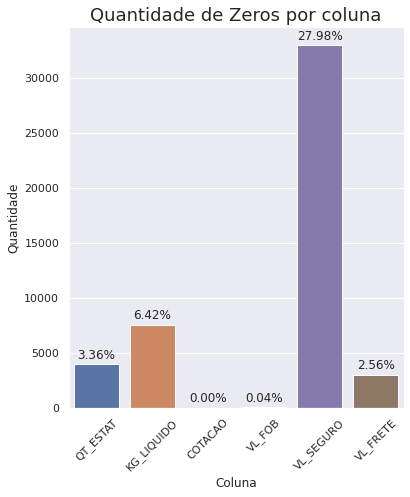

In [206]:
# Plotando a quantidade percentual de zeros de cada coluna do df_total em um gráfico
fig, ax =plt.subplots(figsize=(6,7))
sns.barplot(x=df_contador.Coluna, y = df_contador.Quantidade)
plt.title("Quantidade de Zeros por coluna", fontsize=18)
for i,p in enumerate(ax.patches):
    ax.annotate('{:.2f}%'.format((df_contador.porcentagem[i])*100), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xticks(rotation=45)
plt.show()

In [207]:
# Substituindo os valroes 0 por 1 nas colunas QT_ESTAT, KG_LIQUIDO e VL_FOB no df_total
df_total['QT_ESTAT'] = df_total[['QT_ESTAT']].replace(0,1)
df_total['KG_LIQUIDO'] = df_total[['KG_LIQUIDO']].replace(0,1)
df_total['VL_FOB'] = df_total[['VL_FOB']].replace(0,1)

## Análise e Exploração dos Dados
---


### Análise das NCM importadas
-----


In [208]:
# Agrupando o valor FOB total por NCM
df = df_total.groupby(['NCM']).sum().sort_values(by=['VL_FOB'],ascending=False)
df = df[['VL_FOB']]

# Criando coluna que indica o percentual de participação de cada NCM no valor FOB total
fob_total = df.VL_FOB.sum()
df['porcentagem'] = df.VL_FOB.apply(lambda x: x/fob_total)
df.reset_index(inplace=True)

# Criando coluna extraindo somente o código da NCM com 8 dígitos
df["CO_NCM"] = df["NCM"].apply(lambda x: str(x)[:8])

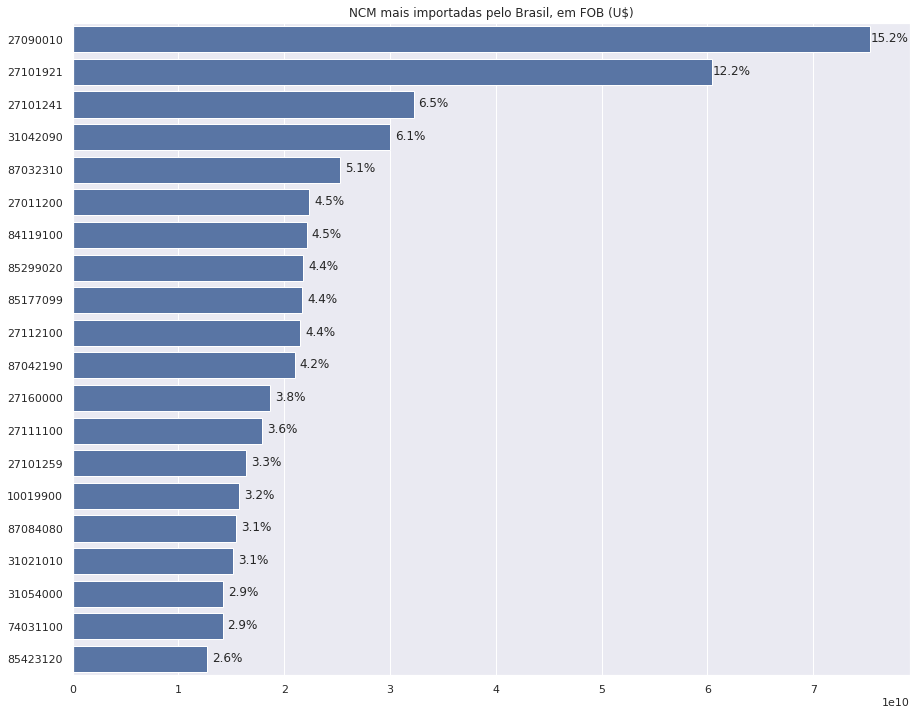

In [209]:
# Visualização das NCM pertencentes ao escopo
sns.set_theme(style="darkgrid")

# Inicializacao figura matplotlib
f, ax = plt.subplots(figsize=(15, 12))
bar = sns.barplot(x=list(df.VL_FOB)[:], y=list(df.CO_NCM)[:],
            label="Total", color="b")

  
for i,p in enumerate(ax.patches):
    ax.annotate('{:.1f}%'.format((df.porcentagem[i])*100), 
                   (p.get_width() + p.get_x(), p.get_y()), 
                   ha = 'center', va = 'center', 
                   xytext = (20, -12), 
                   textcoords = 'offset points')

    
ax.set_title("NCM mais importadas pelo Brasil, em FOB (U$)")
plt.show()

In [210]:
# Criando dataset, a partir do df_total, com as colunas da NCM e do valor do frete
df_dist_ncm = df_total[['NCM','VL_FRETE']]
df_dist_ncm["CO_NCM"] = df_dist_ncm["NCM"].apply(lambda x: str(x)[:8])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


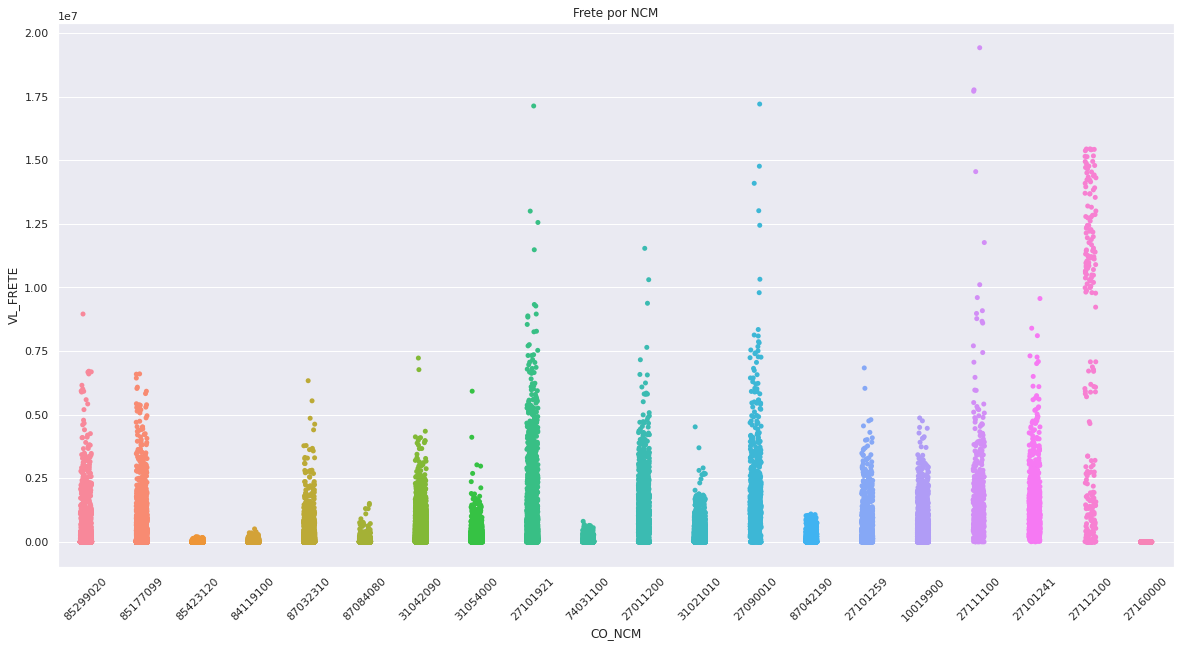

In [211]:
# Plotando gráfico de distribuição stripplot do valor do frete por cada NCM
fig, ax1 = plt.subplots(sharey=False, figsize=(20,10))
plt.title("Frete por NCM")
sns.stripplot(x='CO_NCM', y='VL_FRETE', data=df_dist_ncm, ax=ax1)
plt.xticks(rotation=45)
plt.show()
#plt.savefig('imagens/tipoCE2.png',bbox_inches='tight')

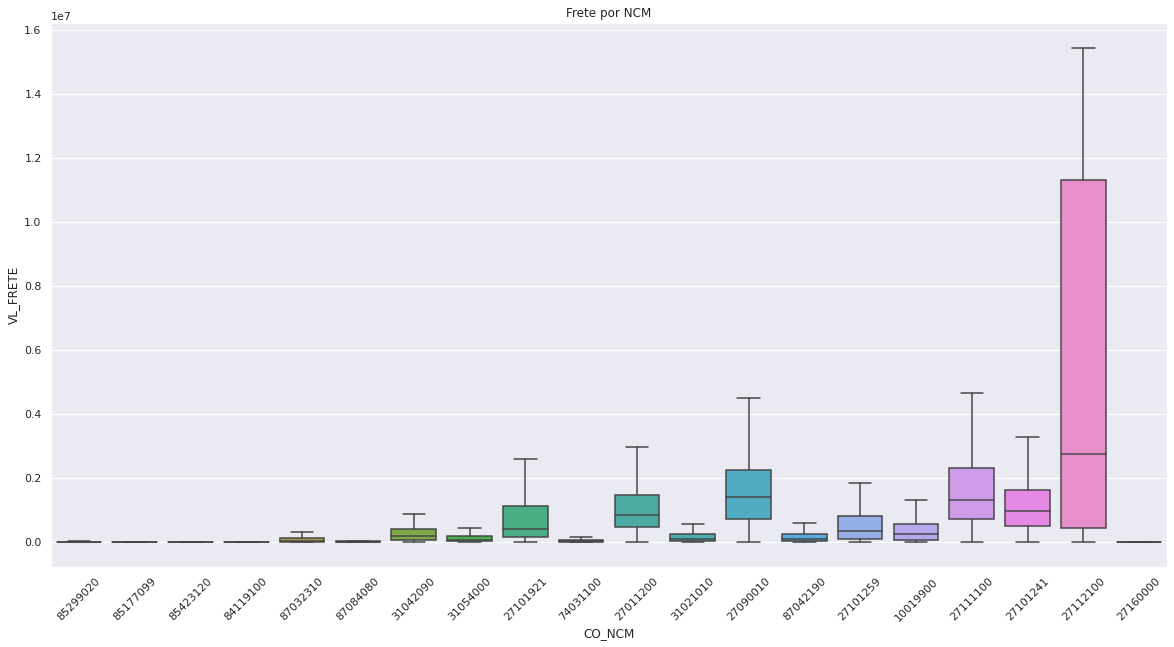

In [212]:
# Plotando gráfico de distribuição boxplot do valor do frete por cada NCM
fig, ax2 = plt.subplots(sharey=False, figsize=(20,10))
plt.title("Frete por NCM")
sns.boxplot(x='CO_NCM', y='VL_FRETE', data=df_dist_ncm, showfliers = False, ax=ax2)
plt.xticks(rotation=45)
plt.show()
#plt.savefig('imagens/tipoCE2.png',bbox_inches='tight')

### Análise das Unidades Estatísticas

In [213]:
# Criando dataset, a partir do df_total, com as colunas da NCM e código da unidade estatística
df_unidest = df_total[['NCM','CO_UNID']]
df_unidest["NCM"] = df_unidest["NCM"].apply(lambda x: str(x)[:8])
df_unidest.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,NCM,CO_UNID
0,85299020,10
1,85177099,10
2,85177099,10
3,85423120,11
4,85423120,11


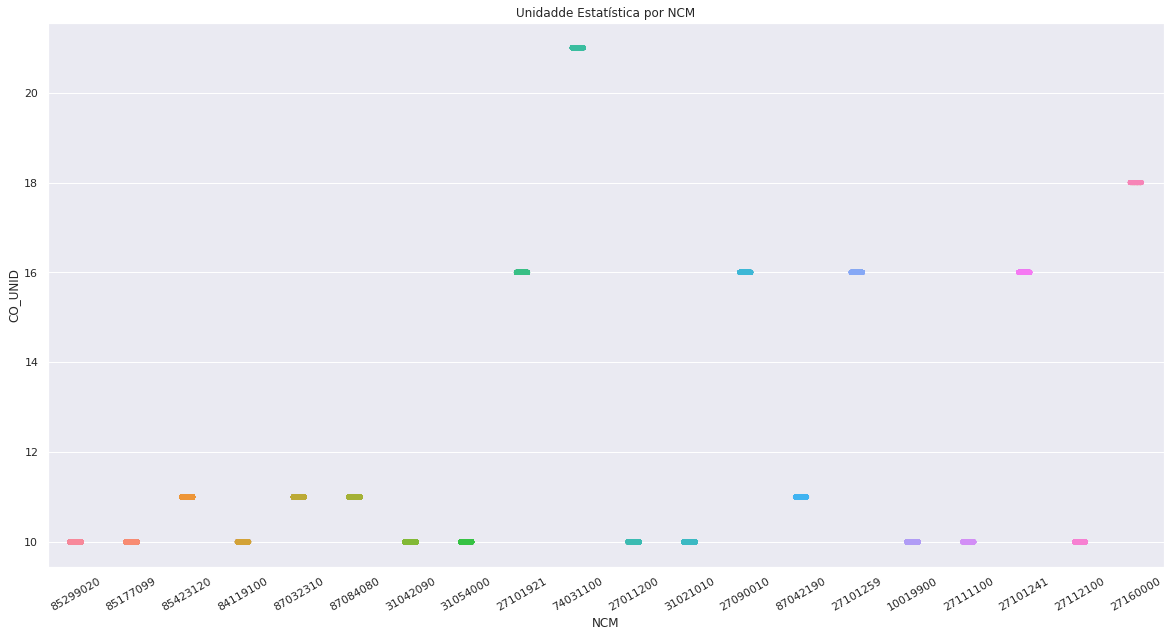

In [214]:
# Plotando gráfico de distribuição stripplot da unidade estatística por cada NCM
fig, ax = plt.subplots(sharey=False, figsize=(20,10))
plt.title("Unidadde Estatística por NCM")
sns.stripplot(x='NCM', y='CO_UNID', data=df_unidest)
plt.xticks(rotation=30)
plt.show()

In [215]:
# Contando a quantidade de vezes e o percentual que cada unidade estatística aparece no df_total
df_contador = df_unidest['CO_UNID'].value_counts()
df_contador = pd.DataFrame({'CO_UNID':df_contador.index, 'Quantidade':df_contador.values})
df_contador['porcentagem'] = df_contador.Quantidade.apply(lambda x: x/quant_total)*100
df_contador

,CO_UNID,Quantidade,porcentagem
0,10,72671,61.682822
1,11,38187,32.412956
2,16,5189,4.404400
3,21,1496,1.269798
4,18,271,0.230024


In [216]:
# Removendo as colunas CO_UNID e QT_ESTAT do df_total
df_total.drop(['CO_UNID','QT_ESTAT'],axis=1,inplace=True)

In [219]:
# Exibindo o cabeçalho do df_total
df_total.head()

,CO_ANO,CO_MES,NCM,NO_PAIS,SG_UF_NCM,NO_VIA,NO_URF,KG_LIQUIDO,COTACAO,VL_FOB,VL_SEGURO,VL_FRETE
0,2012,6,85299020 - Outras partes para aparelhos recept...,Hong Kong,SP,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,35,2.0506,3252,3,538
1,2012,6,85177099 - Outras partes para aparelhos de tel...,Hong Kong,SP,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,356,2.0506,44496,40,6150
2,2012,6,85177099 - Outras partes para aparelhos de tel...,Hong Kong,AM,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,82,2.0506,116919,82,1334
3,2012,6,"85423120 - Processadores e controladores, mesm...",Hong Kong,SC,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,120,2.0506,22194,46,1861
4,2012,6,"85423120 - Processadores e controladores, mesm...",Hong Kong,SP,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,96,2.0506,72146,8,1328


### Análise dos Países Exportadores
-----


In [291]:
# Verificando a quantidade de países distintos que aparecem no dataset df_total
qt_paises = df_total[['NO_PAIS']].nunique()
qt_paises

NO_PAIS    38
dtype: int64

In [260]:
# Agrupando o valor FOB total por país exportador
df = df_total.groupby(['NO_PAIS']).sum().sort_values(by=['VL_FOB'],ascending=False)
df = df[['VL_FOB']]

# Criando coluna que indica o percentual de participação de cada país exportador no valor FOB total
fob_total = df.VL_FOB.sum()
df['porcentagem'] = df.VL_FOB.apply(lambda x: x/fob_total)
df.reset_index(inplace=True)

In [261]:
# Verificando o percentual que os países selecionados representam do valor FOB total
fob_total = df.VL_FOB.sum()
maiores_paises = df.iloc[:37,:]
fob_maiores_paises = maiores_paises.VL_FOB.sum()
perc_paises = fob_maiores_paises/fob_total
print(f'O percentual que esses países representam no valor FOB é de {perc_paises:.1%}')

O percentual que esses países representam no valor FOB é de 95.4%


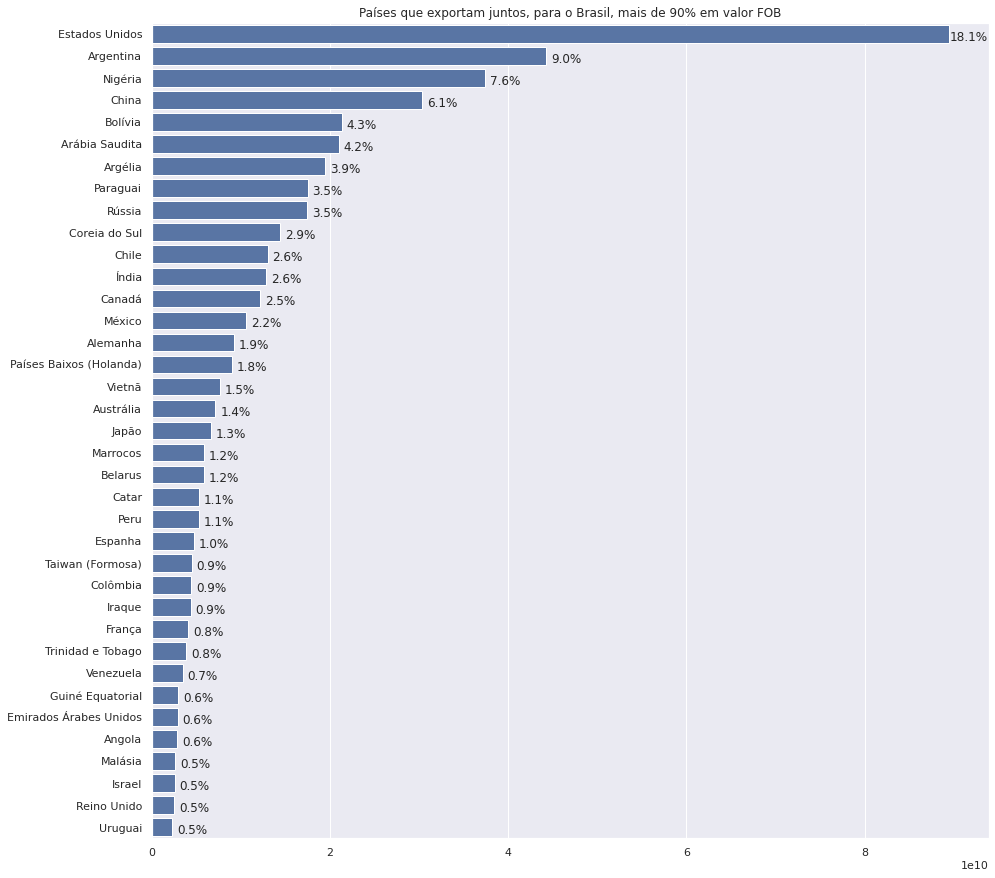

In [262]:
# Visualização dos países que exportam juntos, para o Brasil, mais de 95% em valor FOB
sns.set_theme(style="darkgrid")

# Inicializacao figura matplotlib
f, ax = plt.subplots(figsize=(15, 15))
bar = sns.barplot(x=list(df.VL_FOB)[:37], y=list(df.NO_PAIS)[:37],
            label="Total", color="b")

  
for i,p in enumerate(ax.patches):
    ax.annotate('{:.1f}%'.format((df.porcentagem[i])*100), 
                   (p.get_width() + p.get_x(), p.get_y()), 
                   ha = 'center', va = 'center', 
                   xytext = (20, -12), 
                   textcoords = 'offset points')

    
ax.set_title("Países que exportam juntos, para o Brasil, mais de 90% em valor FOB")
plt.show()

In [263]:
maiores_paises.NO_PAIS

0              Estados Unidos
1                   Argentina
2                     Nigéria
3                       China
4                     Bolívia
5              Arábia Saudita
6                     Argélia
7                    Paraguai
8                      Rússia
9               Coreia do Sul
10                      Chile
11                      Índia
12                     Canadá
13                     México
14                   Alemanha
15    Países Baixos (Holanda)
16                     Vietnã
17                  Austrália
18                      Japão
19                   Marrocos
20                    Belarus
21                      Catar
22                       Peru
23                    Espanha
24           Taiwan (Formosa)
25                   Colômbia
26                     Iraque
27                     França
28          Trinidad e Tobago
29                  Venezuela
30           Guiné Equatorial
31     Emirados Árabes Unidos
32                     Angola
33        

In [264]:
df_total.NO_PAIS = df_total.NO_PAIS.apply(lambda x : 'OUTROS' if x not in list(maiores_paises.NO_PAIS) else x)

In [265]:
df_total.head()

,CO_ANO,CO_MES,NCM,NO_PAIS,SG_UF_NCM,NO_VIA,NO_URF,KG_LIQUIDO,COTACAO,VL_FOB,VL_SEGURO,VL_FRETE
0,2012,6,85299020 - Outras partes para aparelhos recept...,OUTROS,SP,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,35,2.0506,3252,3,538
1,2012,6,85177099 - Outras partes para aparelhos de tel...,OUTROS,SP,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,356,2.0506,44496,40,6150
2,2012,6,85177099 - Outras partes para aparelhos de tel...,OUTROS,AM,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,82,2.0506,116919,82,1334
3,2012,6,"85423120 - Processadores e controladores, mesm...",OUTROS,SC,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,120,2.0506,22194,46,1861
4,2012,6,"85423120 - Processadores e controladores, mesm...",OUTROS,SP,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,96,2.0506,72146,8,1328


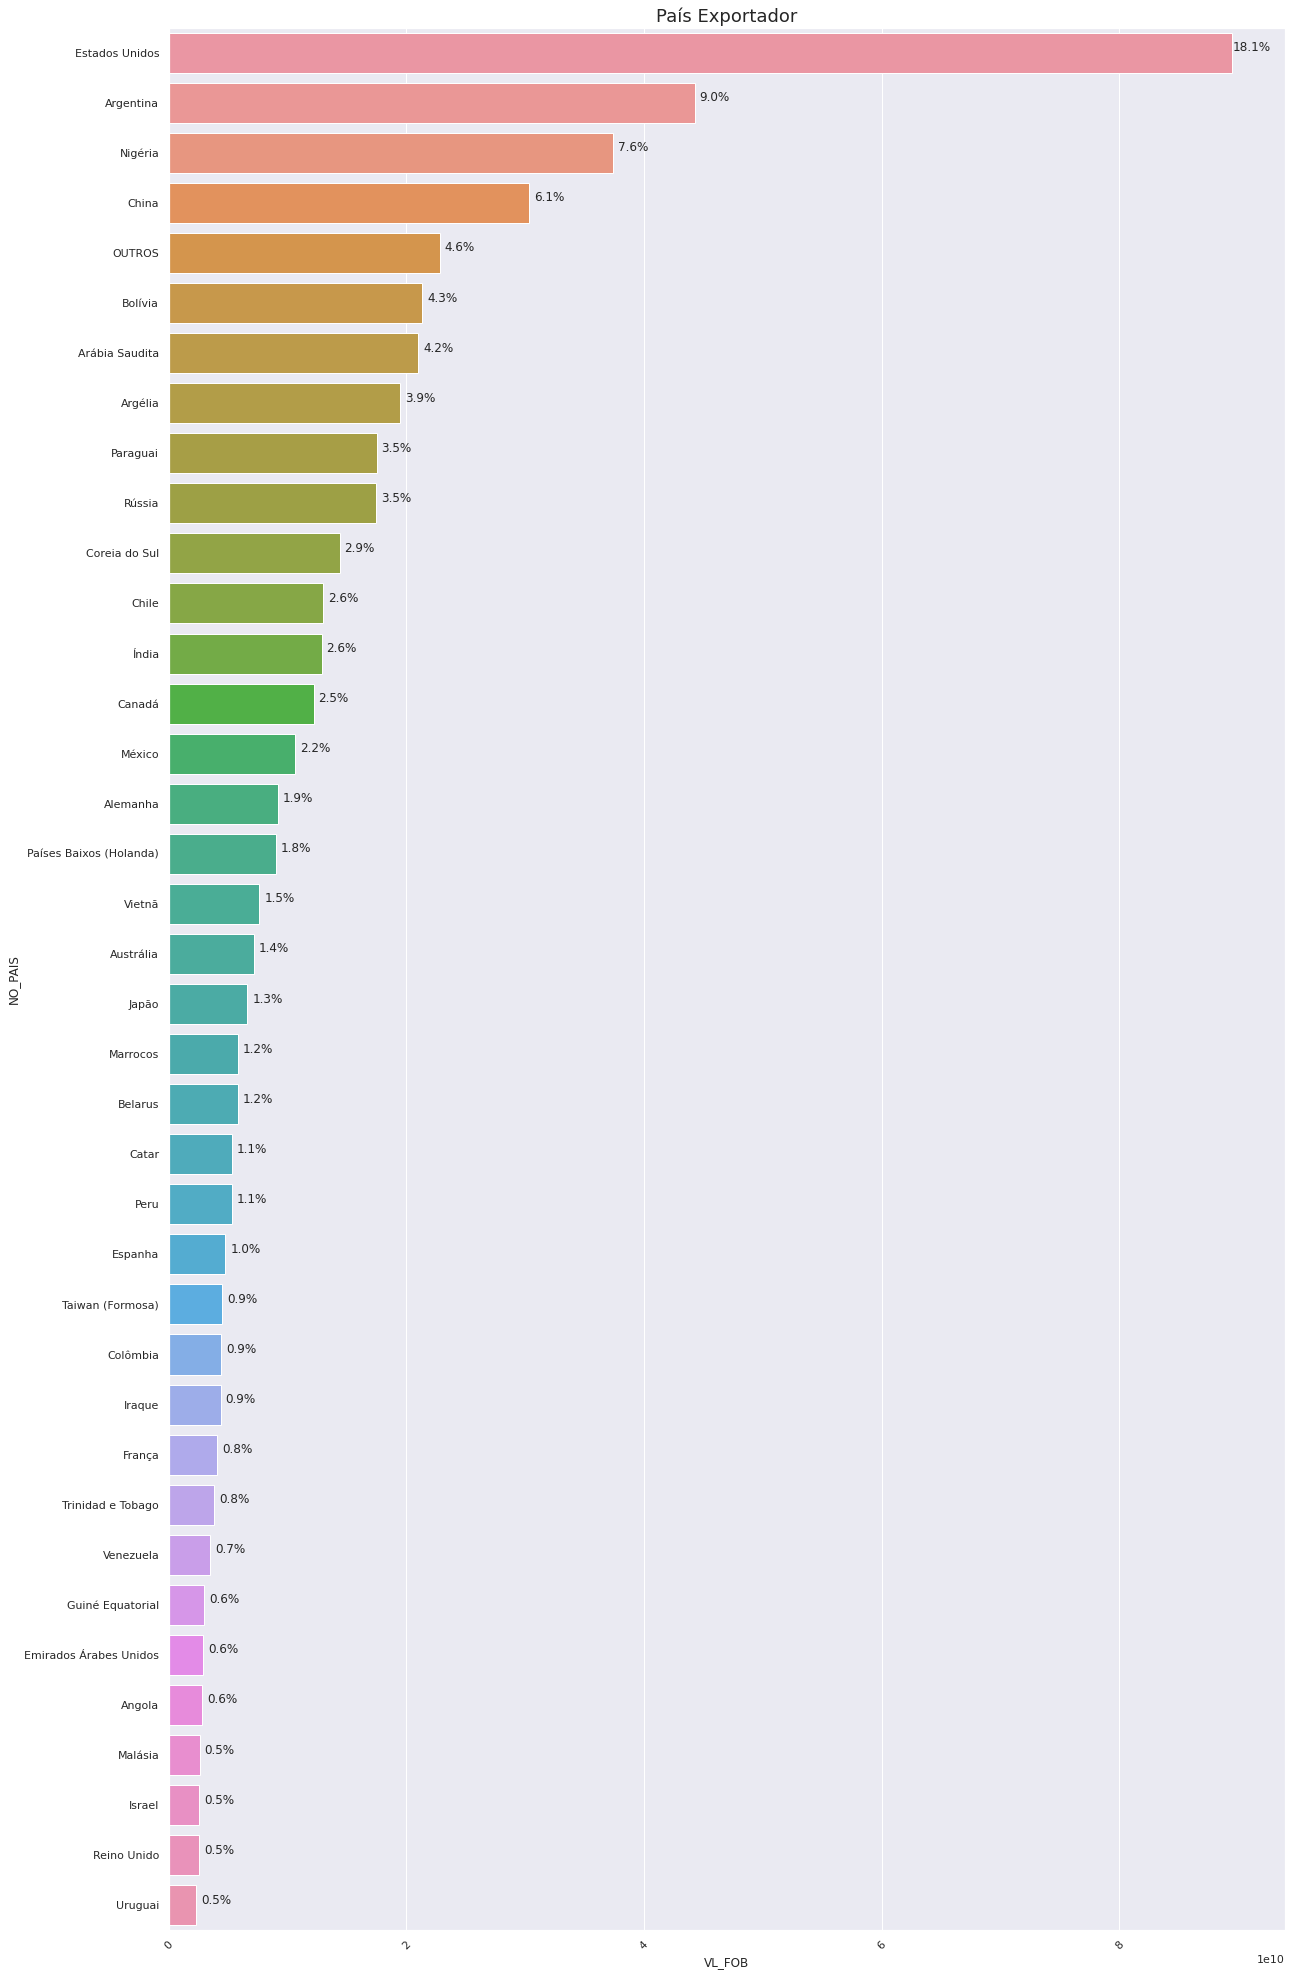

In [284]:
df = df_total.groupby(['NO_PAIS']).sum().sort_values(by=['VL_FOB'],ascending=False)
df = df[['VL_FOB']]
fob_total = df.VL_FOB.sum()
df['porcentagem'] = df.VL_FOB.apply(lambda x: x/fob_total)
df.reset_index(inplace=True)

fig, ax =plt.subplots(figsize=(20,35))
sns.barplot(y=df['NO_PAIS'], x = df['VL_FOB'])
plt.title("País Exportador", fontsize=18)

for i,p in enumerate(ax.patches):
    ax.annotate('{:.1f}%'.format((df.porcentagem[i])*100), 
                   (p.get_width() + p.get_x(), p.get_y()), 
                   ha = 'center', va = 'center', 
                   xytext = (20, -15), 
                   textcoords = 'offset points')


plt.xticks(rotation=45)
plt.show()

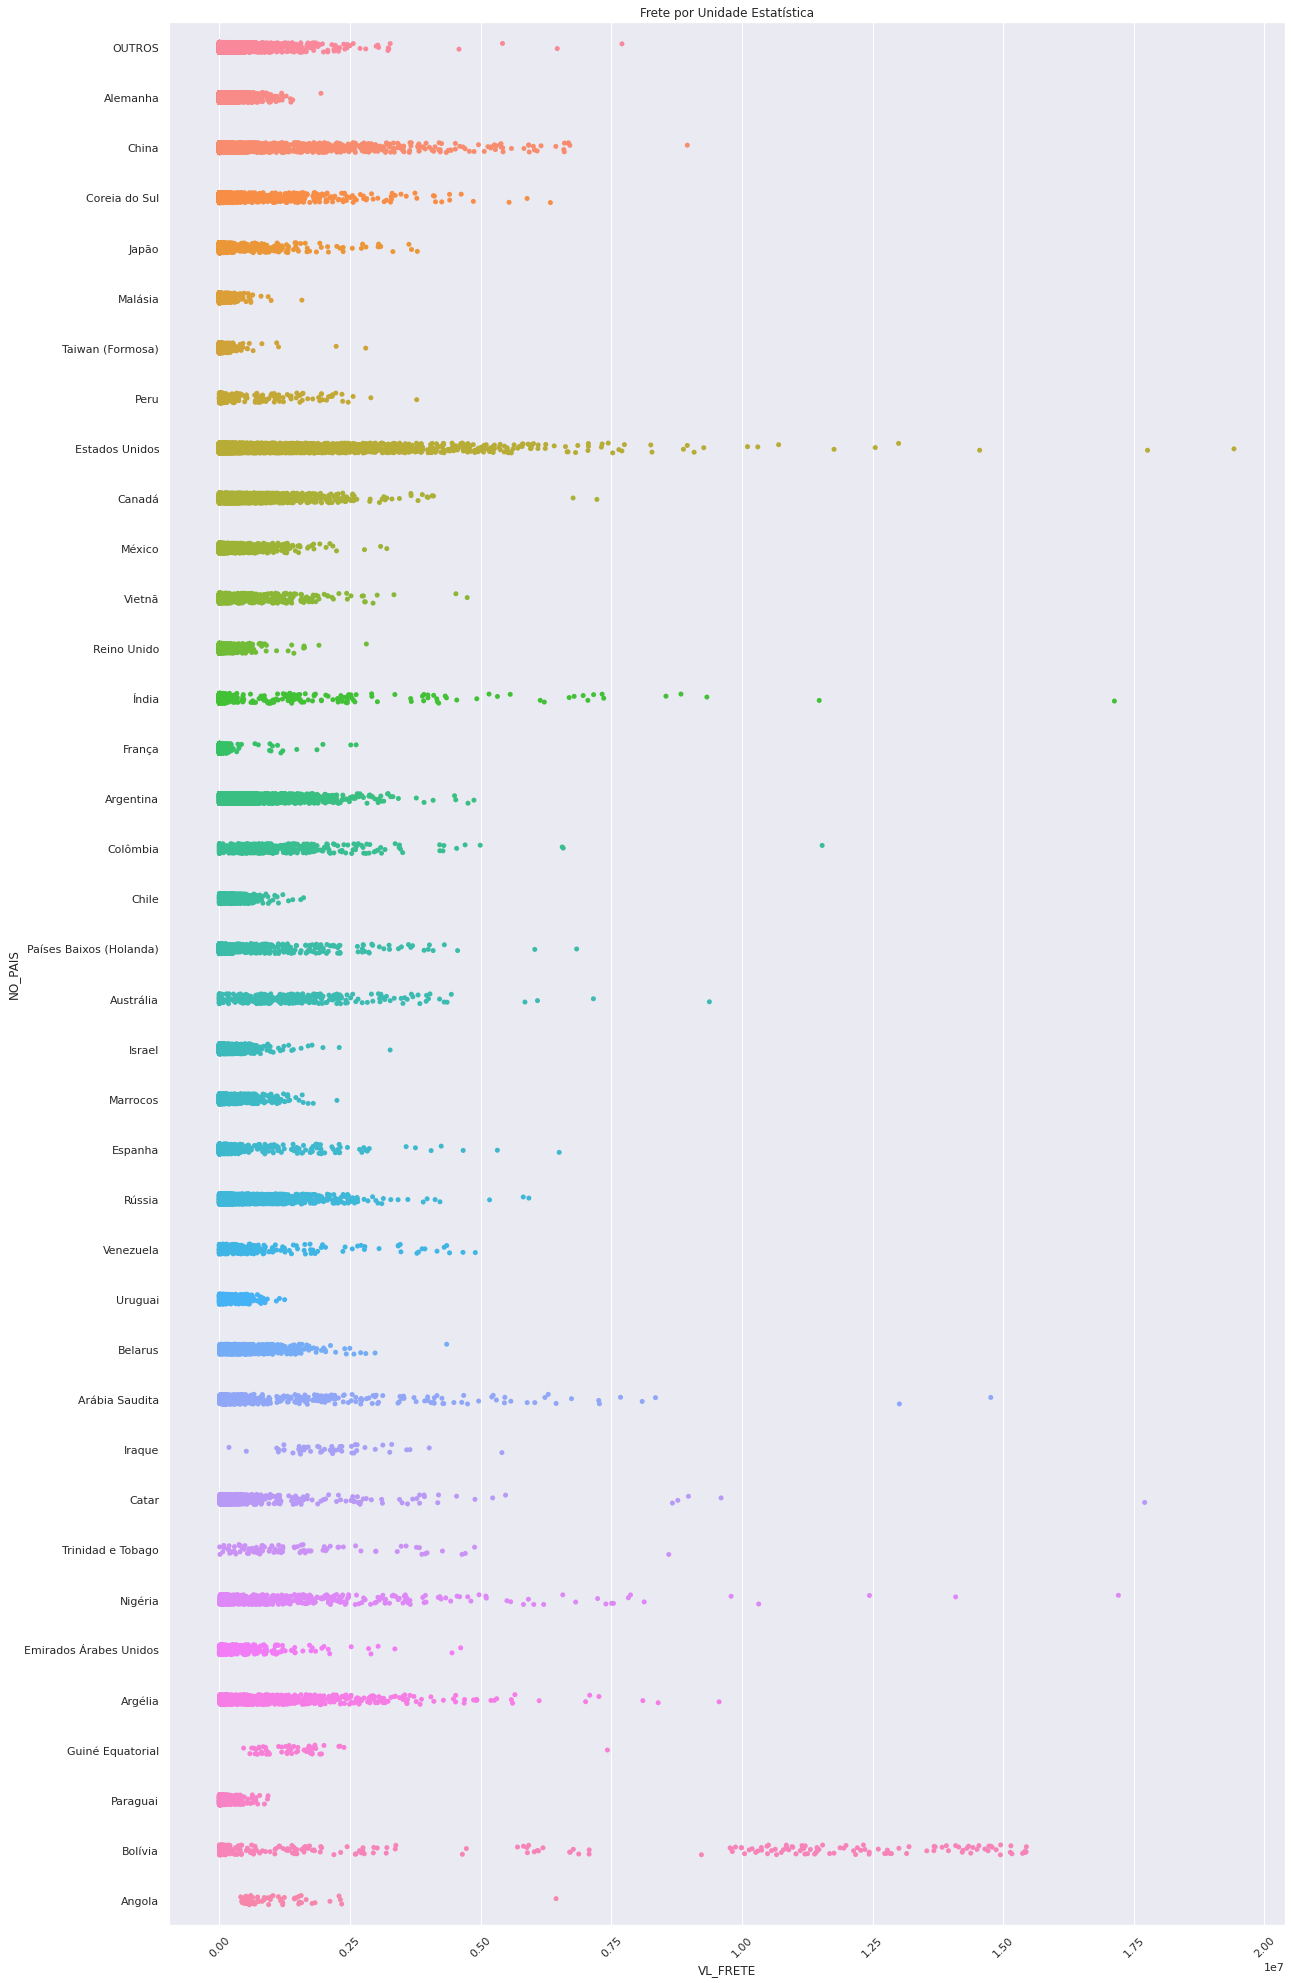

In [287]:
fig, ax1 = plt.subplots(sharey=False, figsize=(20,35))
plt.title("Frete por Unidade Estatística")
sns.stripplot(y='NO_PAIS', x='VL_FRETE', data=df_total, ax=ax1)
plt.xticks(rotation=45)
plt.show()
#plt.savefig('imagens/tipoCE2.png',bbox_inches='tight')

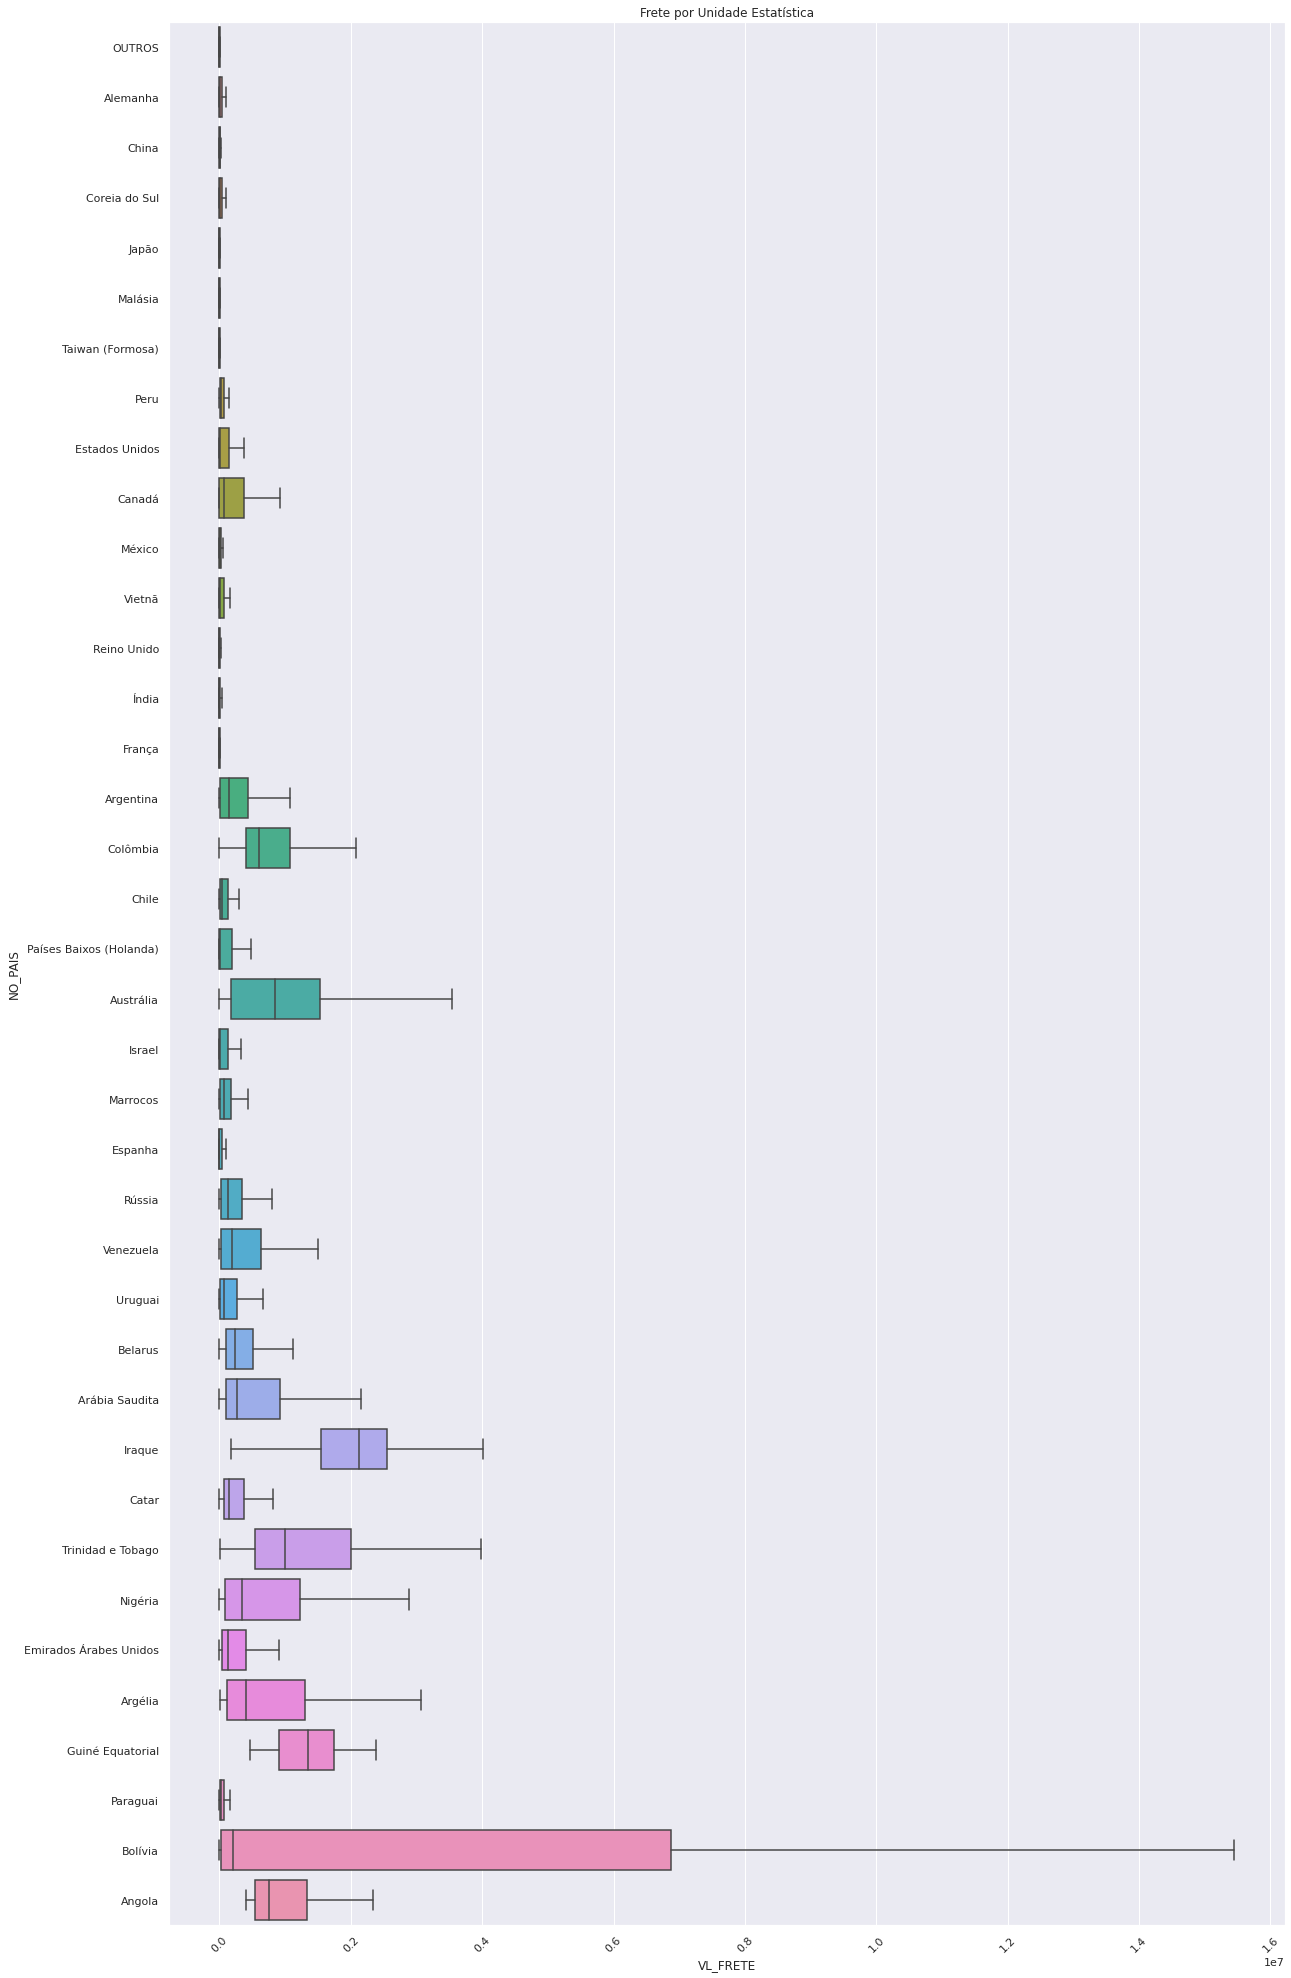

In [288]:
fig, ax2 = plt.subplots(sharey=False, figsize=(20,35))
plt.title("Frete por Unidade Estatística")
sns.boxplot(y='NO_PAIS', x='VL_FRETE', data=df_total, showfliers = False, ax=ax2)
plt.xticks(rotation=45)
plt.show()
#plt.savefig('imagens/tipoCE2.png',bbox_inches='tight')

### Análise dos Estados de Destino das Mercadorias
-----


In [290]:
# Verificando a quantidade de países distintos que aparecem no dataset df_total
qt_uf = df_total[['SG_UF_NCM']].nunique()
qt_uf

SG_UF_NCM    29
dtype: int64

In [299]:
# Agrupando o valor FOB total por estado de destino
df = df_total.groupby(['SG_UF_NCM']).sum().sort_values(by=['VL_FOB'],ascending=False)
df = df[['VL_FOB']]

# Criando coluna que indica o percentual de participação de cada estado de destino no valor FOB total
fob_total = df.VL_FOB.sum()
df['porcentagem'] = df.VL_FOB.apply(lambda x: x/fob_total)
df.reset_index(inplace=True)


In [302]:
# Verificando o percentual que os países selecionados representam do valor FOB total
fob_total = df.VL_FOB.sum()
maiores_destinos = df.iloc[:15,:]
fob_maiores_destinos = maiores_destinos.VL_FOB.sum()
perc_destinos = fob_maiores_destinos/fob_total
print(f'O percentual que esses destinos representam no valor FOB é de {perc_destinos:.1%}')

O percentual que esses destinos representam no valor FOB é de 96.6%


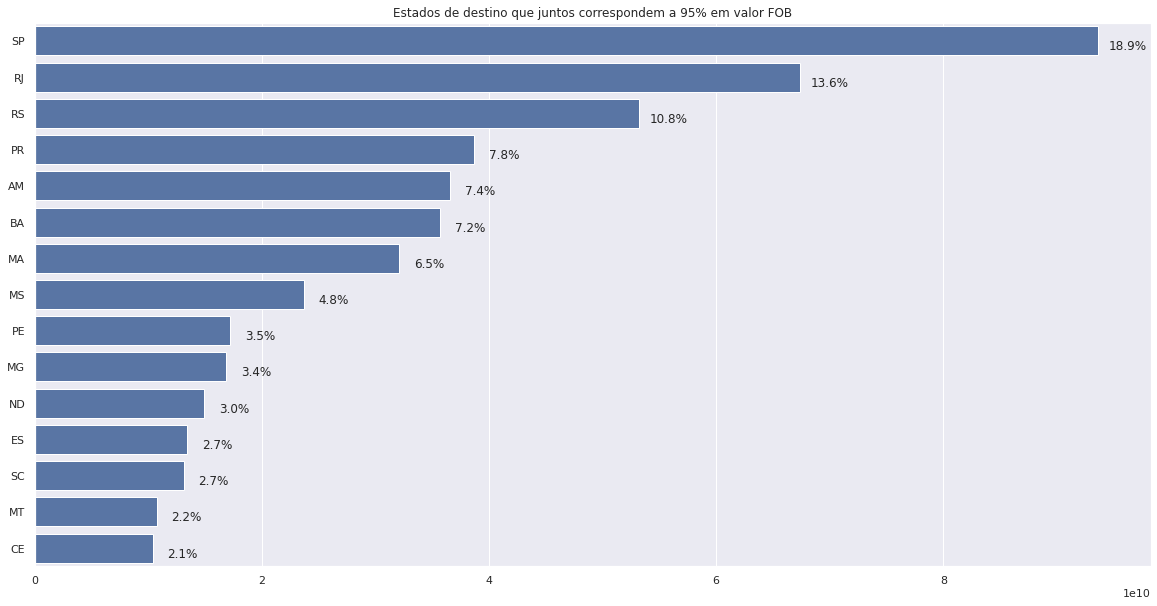

In [298]:
# Visualização dos estados de destino que juntos correspondem a 95% em valor FOB

sns.set_theme(style="darkgrid")

# Inicializacao figura matplotlib
f, ax = plt.subplots(figsize=(20, 10))
bar = sns.barplot(x=list(df.VL_FOB)[:15], y=list(df.SG_UF_NCM)[:15],
            label="Total", color="b")

for i,p in enumerate(ax.patches):
    ax.annotate('{:.1f}%'.format((df.porcentagem[i])*100), 
                   (p.get_width() + p.get_x(), p.get_y()), 
                   ha = 'center', va = 'center', 
                   xytext = (30, -20), 
                   textcoords = 'offset points')   

ax.set_title("Estados de destino que juntos correspondem a 95% em valor FOB")
plt.show()

In [303]:
maiores_destinos.SG_UF_NCM

0     SP
1     RJ
2     RS
3     PR
4     AM
5     BA
6     MA
7     MS
8     PE
9     MG
10    ND
11    ES
12    SC
13    MT
14    CE
Name: SG_UF_NCM, dtype: object

In [304]:
df_total.SG_UF_NCM = df_total.SG_UF_NCM.apply(lambda x : 'OUTROS' if x not in list(maiores_destinos.SG_UF_NCM) else x)

In [305]:
df_total.head()

,CO_ANO,CO_MES,NCM,NO_PAIS,SG_UF_NCM,NO_VIA,NO_URF,KG_LIQUIDO,COTACAO,VL_FOB,VL_SEGURO,VL_FRETE
0,2012,6,85299020 - Outras partes para aparelhos recept...,OUTROS,SP,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,35,2.0506,3252,3,538
1,2012,6,85177099 - Outras partes para aparelhos de tel...,OUTROS,SP,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,356,2.0506,44496,40,6150
2,2012,6,85177099 - Outras partes para aparelhos de tel...,OUTROS,AM,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,82,2.0506,116919,82,1334
3,2012,6,"85423120 - Processadores e controladores, mesm...",OUTROS,SC,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,120,2.0506,22194,46,1861
4,2012,6,"85423120 - Processadores e controladores, mesm...",OUTROS,SP,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,96,2.0506,72146,8,1328


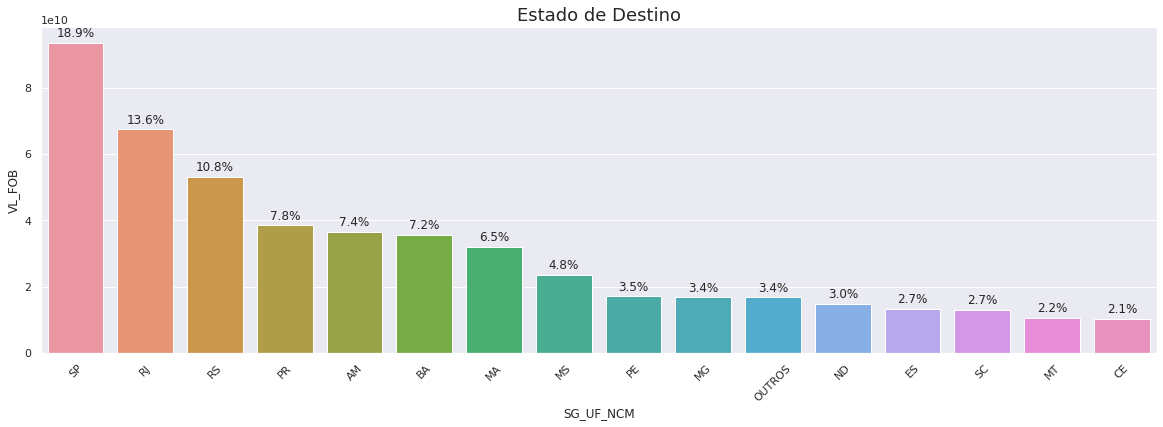

In [306]:
df = df_total.groupby(['SG_UF_NCM']).sum().sort_values(by=['VL_FOB'],ascending=False)
df = df[['VL_FOB']]
fob_total = df.VL_FOB.sum()
df['porcentagem'] = df.VL_FOB.apply(lambda x: x/fob_total)
df.reset_index(inplace=True)

fig, ax =plt.subplots(figsize=(20,6))
sns.barplot(x=df['SG_UF_NCM'], y = df['VL_FOB'])
plt.title("Estado de Destino", fontsize=18)
for i,p in enumerate(ax.patches):
   ax.annotate('{:.1f}%'.format((df.porcentagem[i])*100), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha = 'center', va = 'center', 
                  xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xticks(rotation=45)
plt.show()
#plt.savefig('imagens/tipoCE.png',bbox_inches='tight')

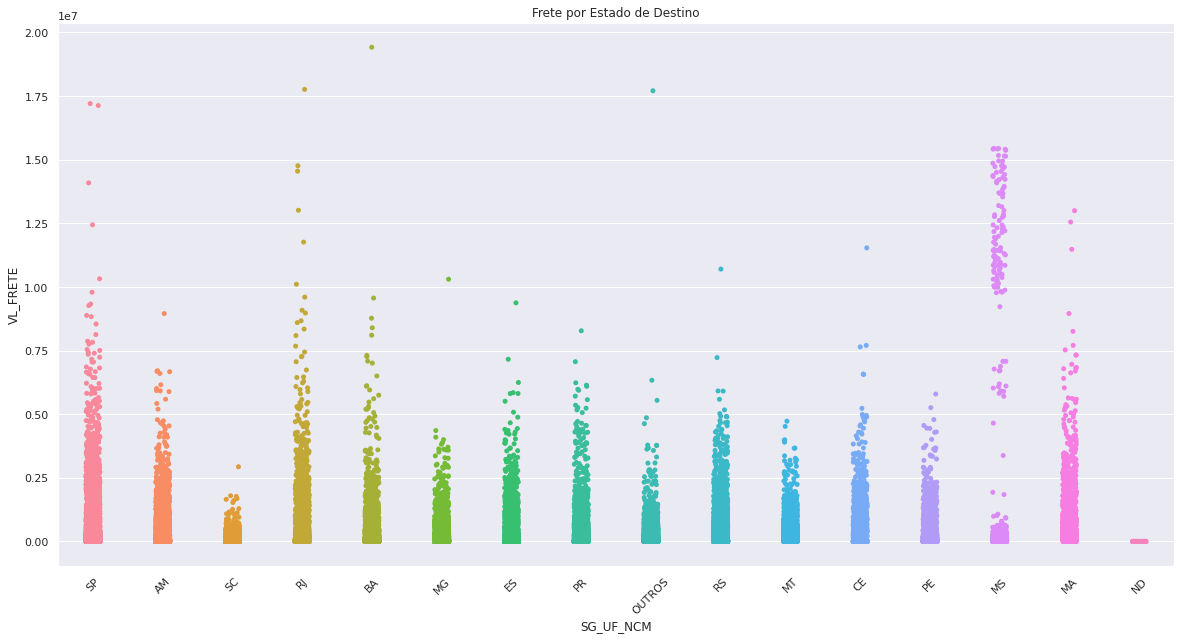

In [307]:
fig, ax1 = plt.subplots(sharey=False, figsize=(20,10))
plt.title("Frete por Estado de Destino")
sns.stripplot(x='SG_UF_NCM', y='VL_FRETE', data=df_total, ax=ax1)
plt.xticks(rotation=45)
plt.show()
#plt.savefig('imagens/tipoCE2.png',bbox_inches='tight')

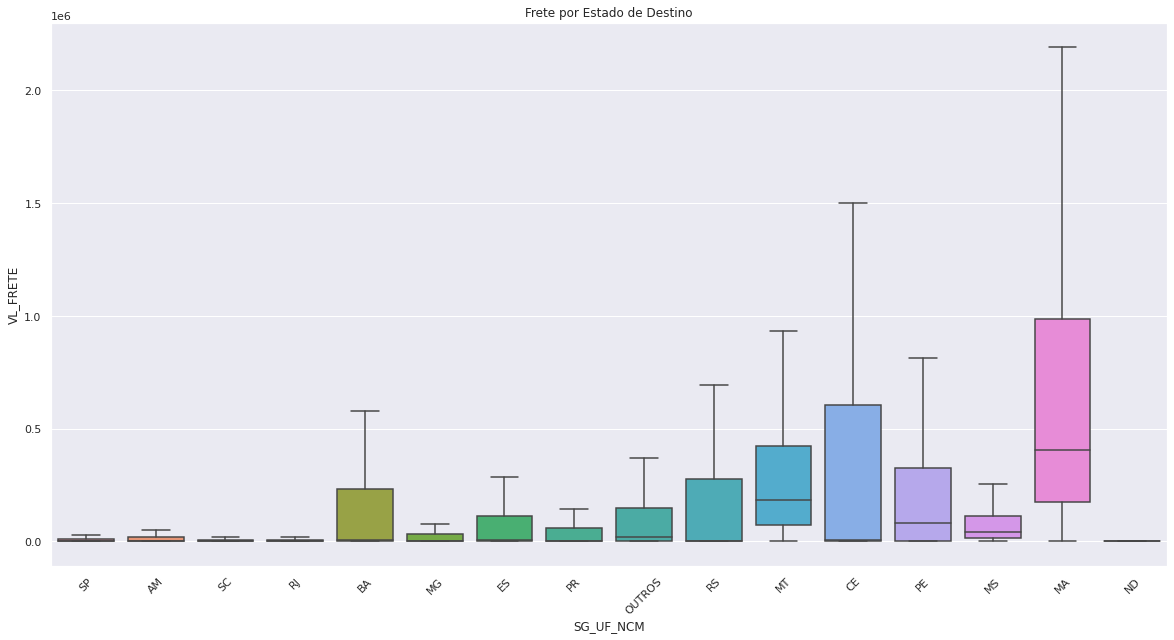

In [308]:
fig, ax2 = plt.subplots(sharey=False, figsize=(20,10))
plt.title("Frete por Estado de Destino")
sns.boxplot(x='SG_UF_NCM', y='VL_FRETE', data=df_total, showfliers = False, ax=ax2)
plt.xticks(rotation=45)
plt.show()
#plt.savefig('imagens/tipoCE2.png',bbox_inches='tight')

### Análise da Via de Transporte
-----


In [310]:
# Verificando a quantidade de vias de transporte distintas que aparecem no dataset df_total
qt_via = df_total[['NO_VIA']].nunique()
qt_via

NO_VIA    9
dtype: int64

In [312]:
df = df_total.groupby(['NO_VIA']).sum().sort_values(by=['VL_FOB'],ascending=False)
df = df[['VL_FOB']]
fob_total = df.VL_FOB.sum()
df['porcentagem'] = df.VL_FOB.apply(lambda x: x/fob_total)
df.reset_index(inplace=True)


In [315]:
fob_total = df.VL_FOB.sum()
maiores_vias = df.iloc[:3,:]
fob_maiores_vias = maiores_vias.VL_FOB.sum()
perc_vias = fob_maiores_vias/fob_total
print(f'O percentual que essas vias de transporte representam no valor FOB é de {perc_vias:.1%}')

O percentual que essas vias de transporte representam no valor FOB é de 97.0%


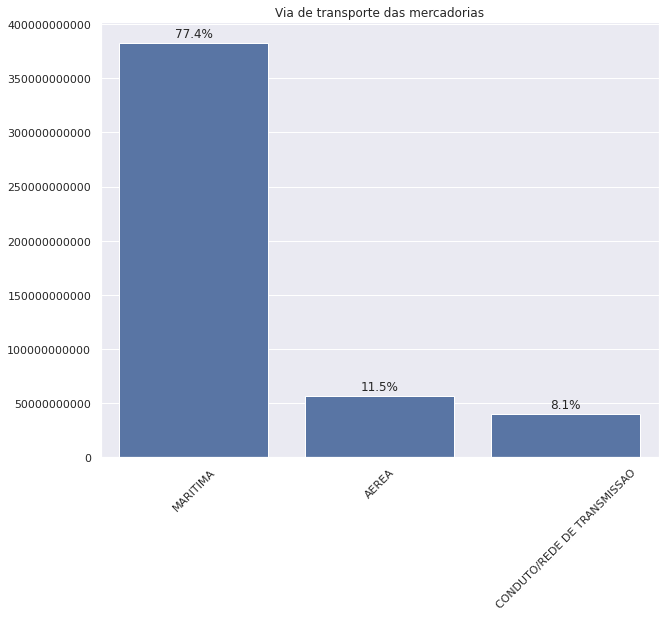

In [320]:
# Visualização das vias de trasponrte que juntas representam mais de 95% em valor FOB

sns.set_theme(style="darkgrid")

# Inicializacao figura matplotlib
f, ax = plt.subplots(figsize=(10, 8))
bar = sns.barplot(y=list(df.VL_FOB)[:3], x=list(df.NO_VIA)[:3],
            label="Total", color="b")

for i,p in enumerate(bar.patches):
    bar.annotate('{:.1f}%'.format((df.porcentagem[i])*100), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    

ax.set_title("Via de transporte das mercadorias")
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: int(y)))
plt.xticks(rotation=45)
plt.show()



In [321]:
maiores_vias.NO_VIA

0                       MARITIMA
1                          AEREA
2    CONDUTO/REDE DE TRANSMISSAO
Name: NO_VIA, dtype: object

In [322]:
df_total.NO_VIA = df_total.NO_VIA.apply(lambda x : 'OUTROS' if x not in list(maiores_vias.NO_VIA) else x)

In [323]:
df_total.head()

,CO_ANO,CO_MES,NCM,NO_PAIS,SG_UF_NCM,NO_VIA,NO_URF,KG_LIQUIDO,COTACAO,VL_FOB,VL_SEGURO,VL_FRETE
0,2012,6,85299020 - Outras partes para aparelhos recept...,OUTROS,SP,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,35,2.0506,3252,3,538
1,2012,6,85177099 - Outras partes para aparelhos de tel...,OUTROS,SP,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,356,2.0506,44496,40,6150
2,2012,6,85177099 - Outras partes para aparelhos de tel...,OUTROS,AM,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,82,2.0506,116919,82,1334
3,2012,6,"85423120 - Processadores e controladores, mesm...",OUTROS,SC,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,120,2.0506,22194,46,1861
4,2012,6,"85423120 - Processadores e controladores, mesm...",OUTROS,SP,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,96,2.0506,72146,8,1328


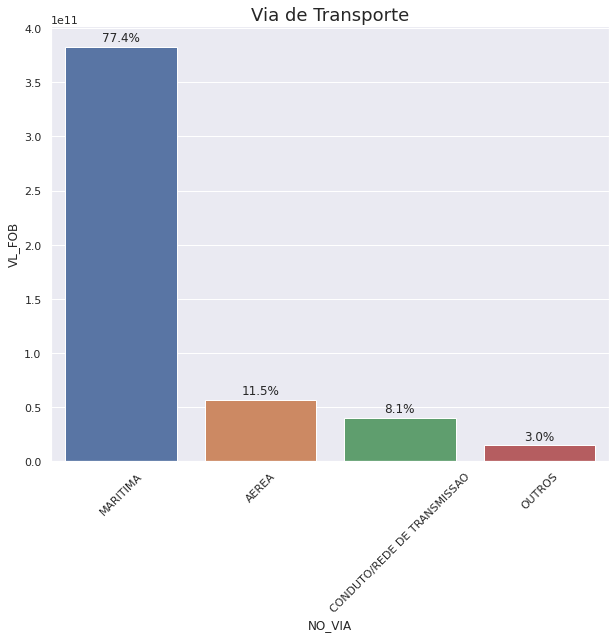

In [326]:
df = df_total.groupby(['NO_VIA']).sum().sort_values(by=['VL_FOB'],ascending=False)
df = df[['VL_FOB']]
fob_total = df.VL_FOB.sum()
df['porcentagem'] = df.VL_FOB.apply(lambda x: x/fob_total)
df.reset_index(inplace=True)

fig, ax =plt.subplots(figsize=(10,8))
sns.barplot(x=df['NO_VIA'], y = df['VL_FOB'])
plt.title("Via de Transporte", fontsize=18)
for i,p in enumerate(ax.patches):
    ax.annotate('{:.1f}%'.format((df.porcentagem[i])*100), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xticks(rotation=45)
plt.show()
#plt.savefig('imagens/tipoCE.png',bbox_inches='tight')

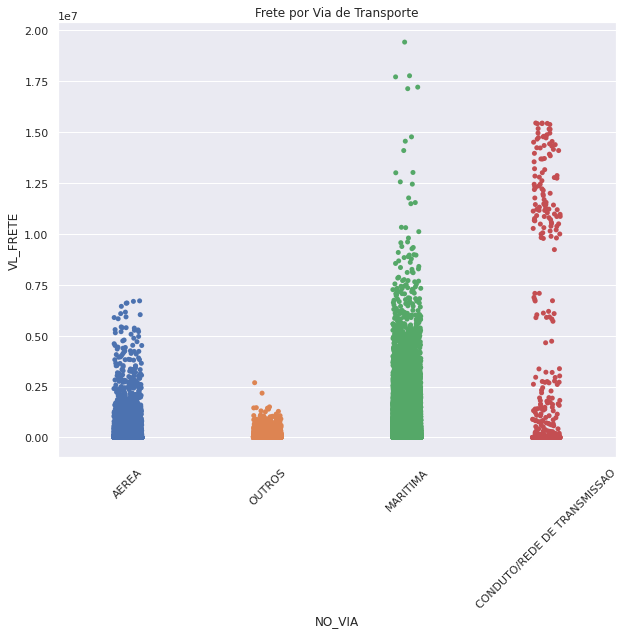

In [328]:
fig, ax1 = plt.subplots(sharey=False, figsize=(10,8))
plt.title("Frete por Via de Transporte")
sns.stripplot(x='NO_VIA', y='VL_FRETE', data=df_total, ax=ax1)
plt.xticks(rotation=45)
plt.show()
#plt.savefig('imagens/tipoCE2.png',bbox_inches='tight')

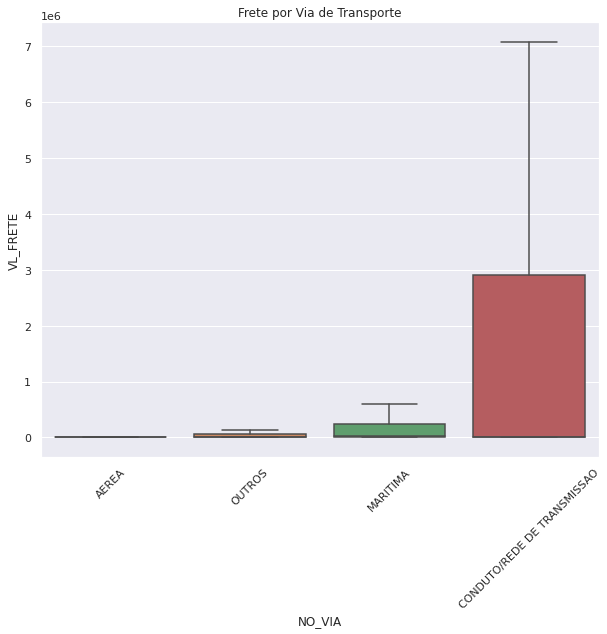

In [330]:
fig, ax2 = plt.subplots(sharey=False, figsize=(10,8))
plt.title("Frete por Via de Transporte")
sns.boxplot(x='NO_VIA', y='VL_FRETE', data=df_total, showfliers = False, ax=ax2)
plt.xticks(rotation=45)
plt.show()
#plt.savefig('imagens/tipoCE2.png',bbox_inches='tight')

### Análise da URF de Desembaraço


In [331]:
# Verificando a quantidade de unidades de desembaraço distintas que aparecem no dataset df_total
qt_urf = df_total[['NO_URF']].nunique()
qt_urf

NO_URF    108
dtype: int64

In [333]:
df = df_total.groupby(['NO_URF']).sum().sort_values(by=['VL_FOB'],ascending=False)
df = df[['VL_FOB']]
fob_total = df.VL_FOB.sum()
df['porcentagem'] = df.VL_FOB.apply(lambda x: x/fob_total)
df.reset_index(inplace=True)

In [337]:
fob_total = df.VL_FOB.sum()
maiores_urf = df.iloc[:30,:]
fob_maiores_urf = maiores_urf.VL_FOB.sum()
perc_urf = fob_maiores_urf/fob_total
print(f'O percentual que essas unidades representam no valor FOB é de {perc_urf:.1%}')

O percentual que essas unidades representam no valor FOB é de 95.7%


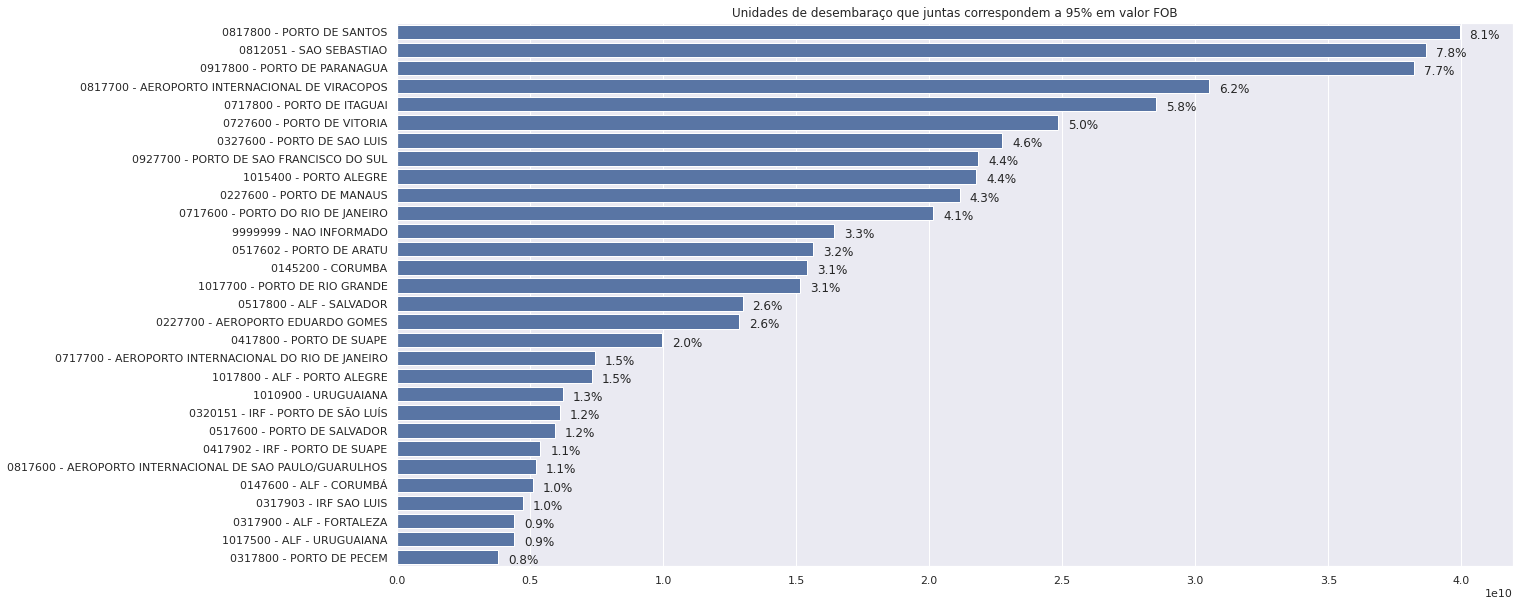

In [338]:
# Visualização dos estados de destino que juntos correspondem a 95% em valor FOB

sns.set_theme(style="darkgrid")

# Inicializacao figura matplotlib
f, ax = plt.subplots(figsize=(20, 10))
bar = sns.barplot(x=list(df.VL_FOB)[:30], y=list(df.NO_URF)[:30],
            label="Total", color="b")

for i,p in enumerate(ax.patches):
    ax.annotate('{:.1f}%'.format((df.porcentagem[i])*100), 
                   (p.get_width() + p.get_x(), p.get_y()), 
                   ha = 'center', va = 'center', 
                   xytext = (25, -10), 
                   textcoords = 'offset points')   

ax.set_title("Unidades de desembaraço que juntas correspondem a 95% em valor FOB")
plt.show()


In [339]:
maiores_urf.NO_URF

0                             0817800 - PORTO DE SANTOS
1                               0812051 - SAO SEBASTIAO
2                          0917800 - PORTO DE PARANAGUA
3        0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS
4                            0717800 - PORTO DE ITAGUAI
5                            0727600 - PORTO DE VITORIA
6                           0327600 - PORTO DE SAO LUIS
7               0927700 - PORTO DE SAO FRANCISCO DO SUL
8                                1015400 - PORTO ALEGRE
9                             0227600 - PORTO DE MANAUS
10                    0717600 - PORTO DO RIO DE JANEIRO
11                              9999999 - NAO INFORMADO
12                             0517602 - PORTO DE ARATU
13                                    0145200 - CORUMBA
14                        1017700 - PORTO DE RIO GRANDE
15                             0517800 - ALF - SALVADOR
16                    0227700 - AEROPORTO EDUARDO GOMES
17                             0417800 - PORTO D

In [340]:
df_total.NO_URF = df_total.NO_URF.apply(lambda x : 'OUTROS' if x not in list(maiores_urf.NO_URF) else x)

In [341]:
df_total

,CO_ANO,CO_MES,NCM,NO_PAIS,SG_UF_NCM,NO_VIA,NO_URF,KG_LIQUIDO,COTACAO,VL_FOB,VL_SEGURO,VL_FRETE
0,2012,6,85299020 - Outras partes para aparelhos recept...,OUTROS,SP,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,35,2.050600,3252,3,538
1,2012,6,85177099 - Outras partes para aparelhos de tel...,OUTROS,SP,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,356,2.050600,44496,40,6150
2,2012,6,85177099 - Outras partes para aparelhos de tel...,OUTROS,AM,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,82,2.050600,116919,82,1334
3,2012,6,"85423120 - Processadores e controladores, mesm...",OUTROS,SC,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,120,2.050600,22194,46,1861
4,2012,6,"85423120 - Processadores e controladores, mesm...",OUTROS,SP,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,96,2.050600,72146,8,1328
...,...,...,...,...,...,...,...,...,...,...,...,...
117809,2012,2,10019900 - Outros trigos e misturas de trigo c...,Paraguai,PR,OUTROS,OUTROS,156000,1.717316,31668,0,312
117810,2012,2,10019900 - Outros trigos e misturas de trigo c...,Paraguai,PR,OUTROS,OUTROS,1500000,1.717316,270000,0,7500
117811,2012,2,10019900 - Outros trigos e misturas de trigo c...,Paraguai,MS,OUTROS,OUTROS,320340,1.717316,69834,0,3844
117812,2012,2,27112100 - Gás natural no estado gasoso,Bolívia,MS,CONDUTO/REDE DE TRANSMISSAO,0145200 - CORUMBA,468795053,1.717316,204558151,0,11544398


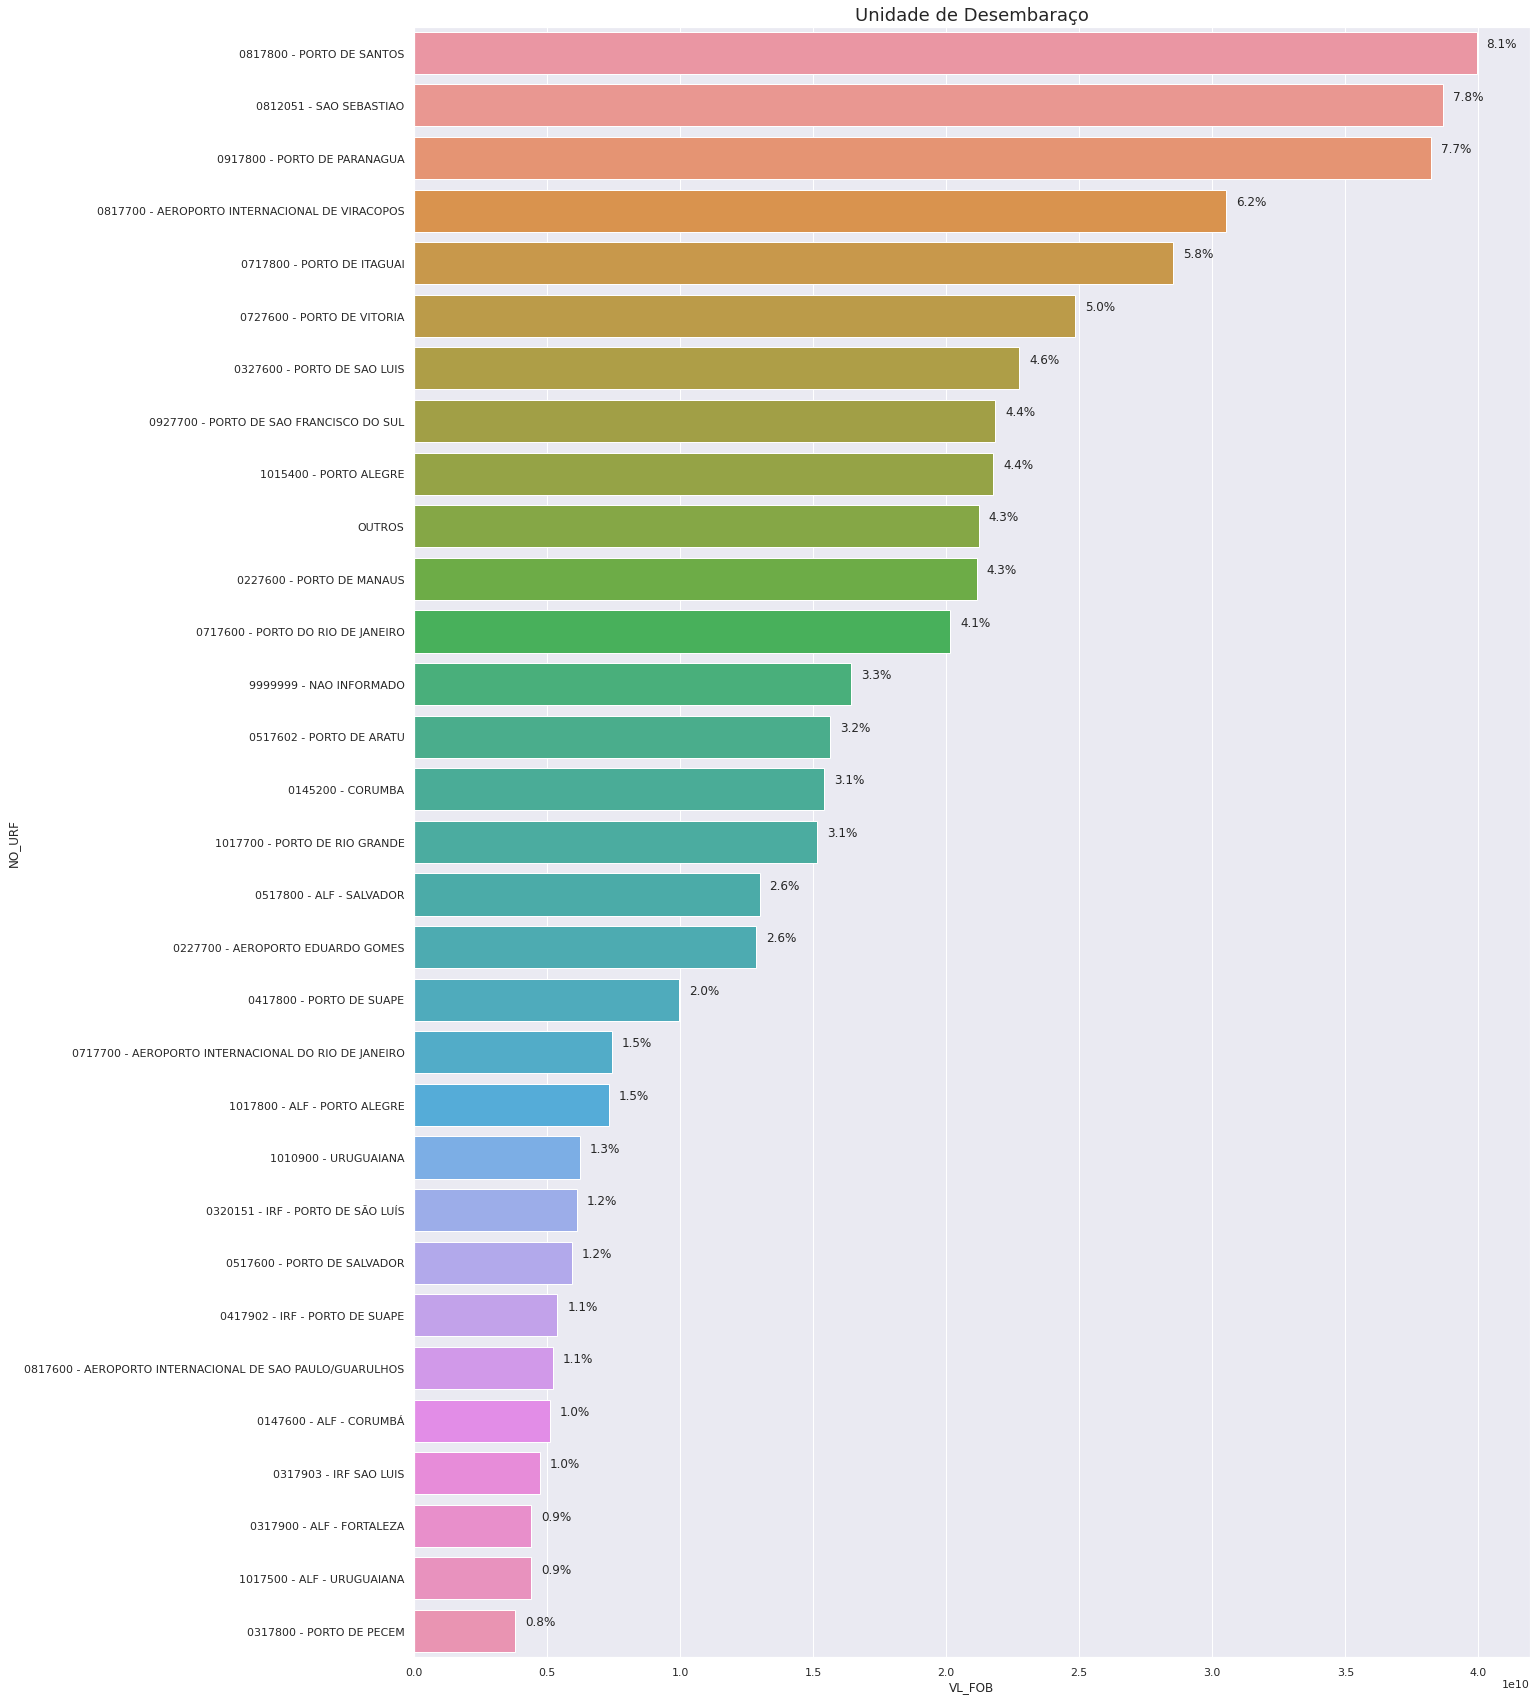

In [353]:
df = df_total.groupby(['NO_URF']).sum().sort_values(by=['VL_FOB'],ascending=False)
df = df[['VL_FOB']]
fob_total = df.VL_FOB.sum()
df['porcentagem'] = df.VL_FOB.apply(lambda x: x/fob_total)
df.reset_index(inplace=True)

fig, ax =plt.subplots(figsize=(20,30))
sns.barplot(y=df['NO_URF'], x = df['VL_FOB'])
plt.title("Unidade de Desembaraço", fontsize=18)
for i,p in enumerate(ax.patches):
    ax.annotate('{:.1f}%'.format((df.porcentagem[i])*100), 
                   (p.get_width() + p.get_x(), p.get_y()), 
                   ha = 'center', va = 'center', 
                   xytext = (25, -12), 
                   textcoords = 'offset points')

plt.show()
#plt.savefig('imagens/tipoCE.png',bbox_inches='tight')

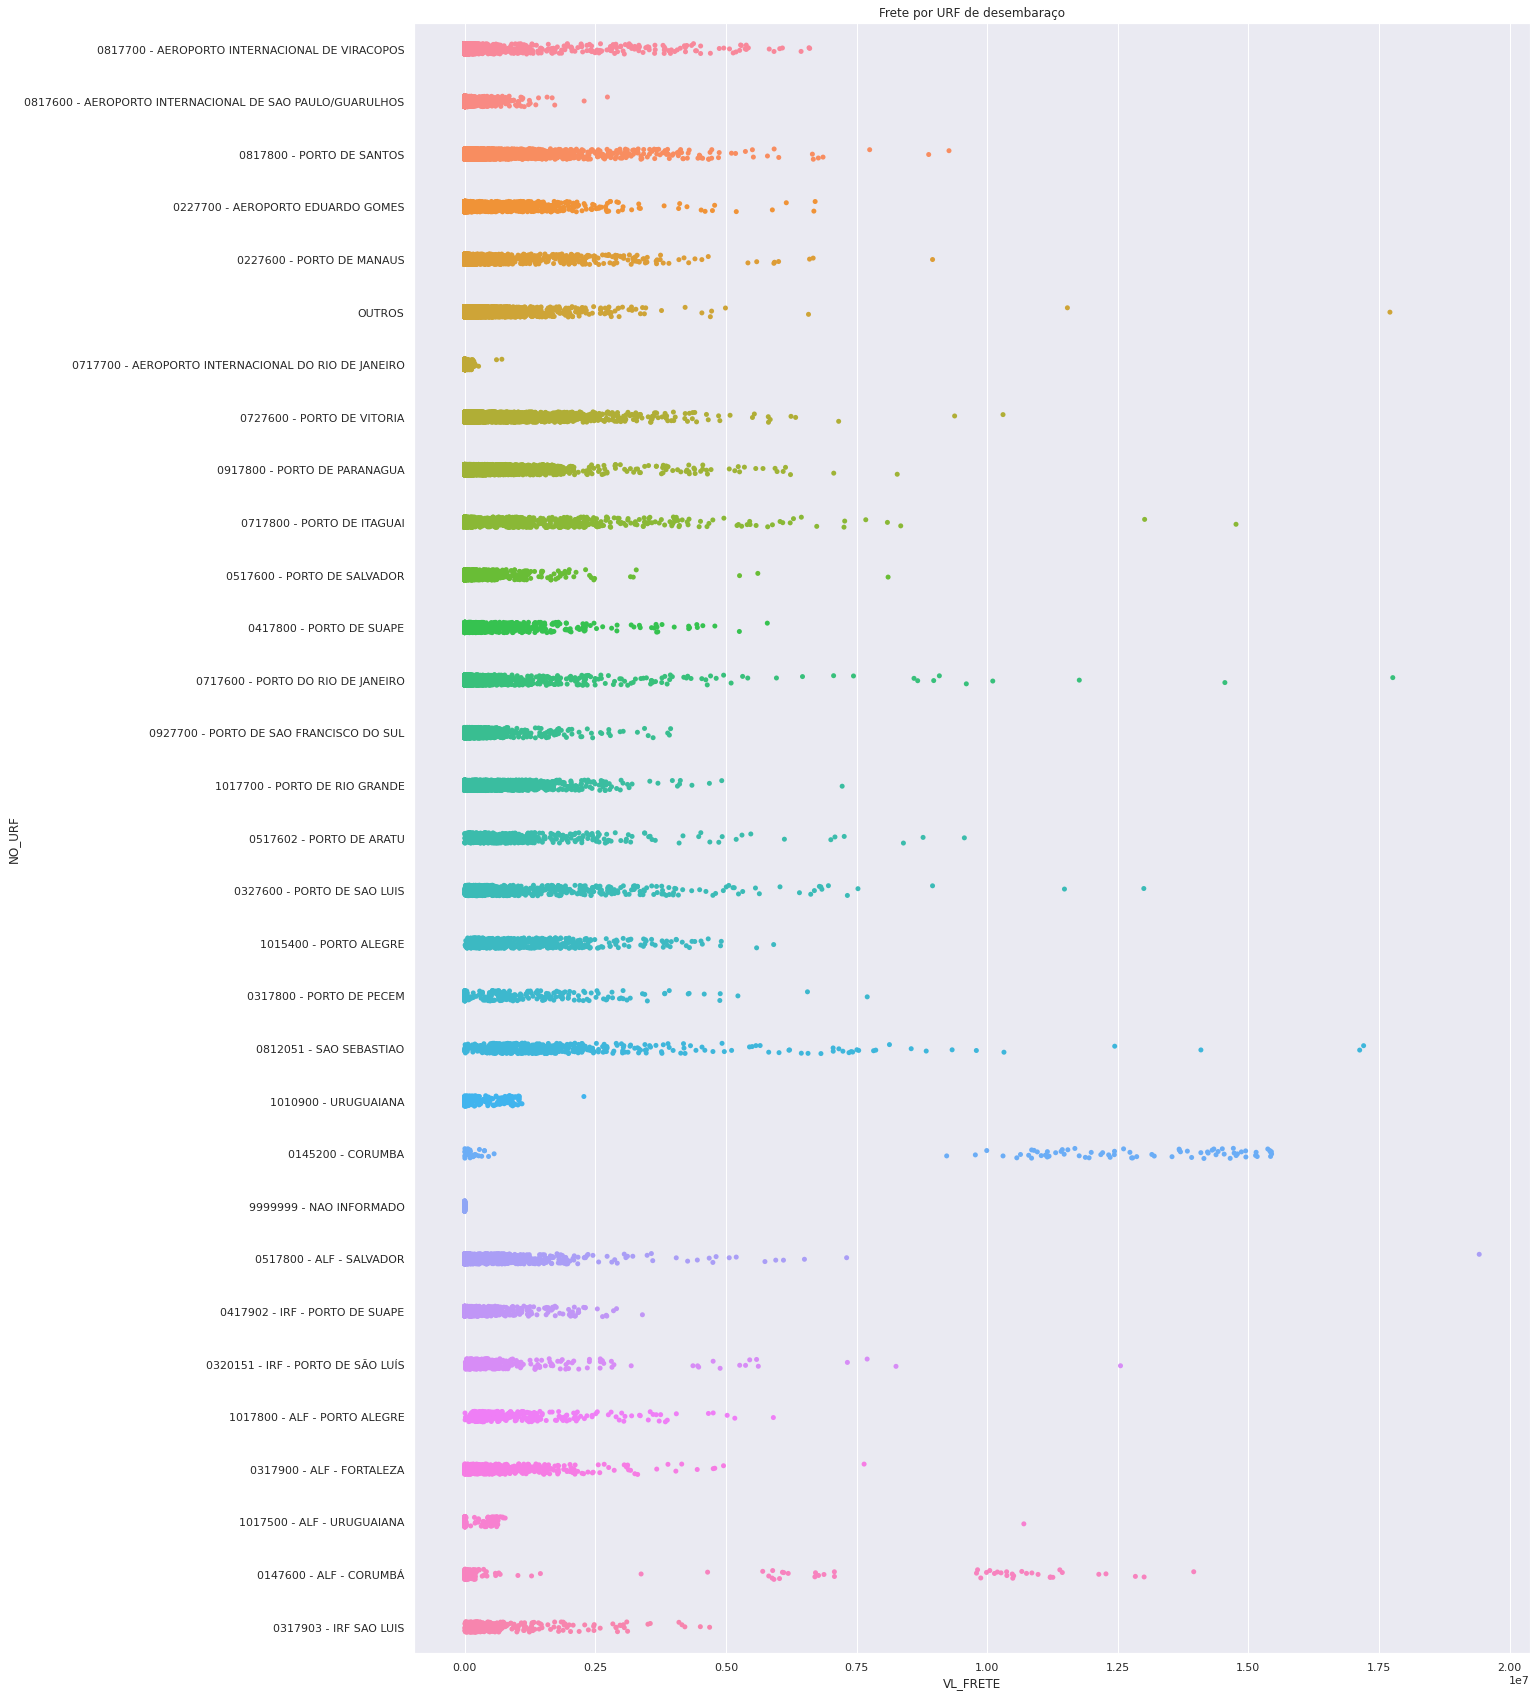

In [354]:
fig, ax1 = plt.subplots(sharey=False, figsize=(20,30))
plt.title("Frete por URF de desembaraço")
sns.stripplot(y='NO_URF', x='VL_FRETE', data=df_total, ax=ax1)
#plt.xticks(rotation=70)
plt.show()
#plt.savefig('imagens/tipoCE2.png',bbox_inches='tight')

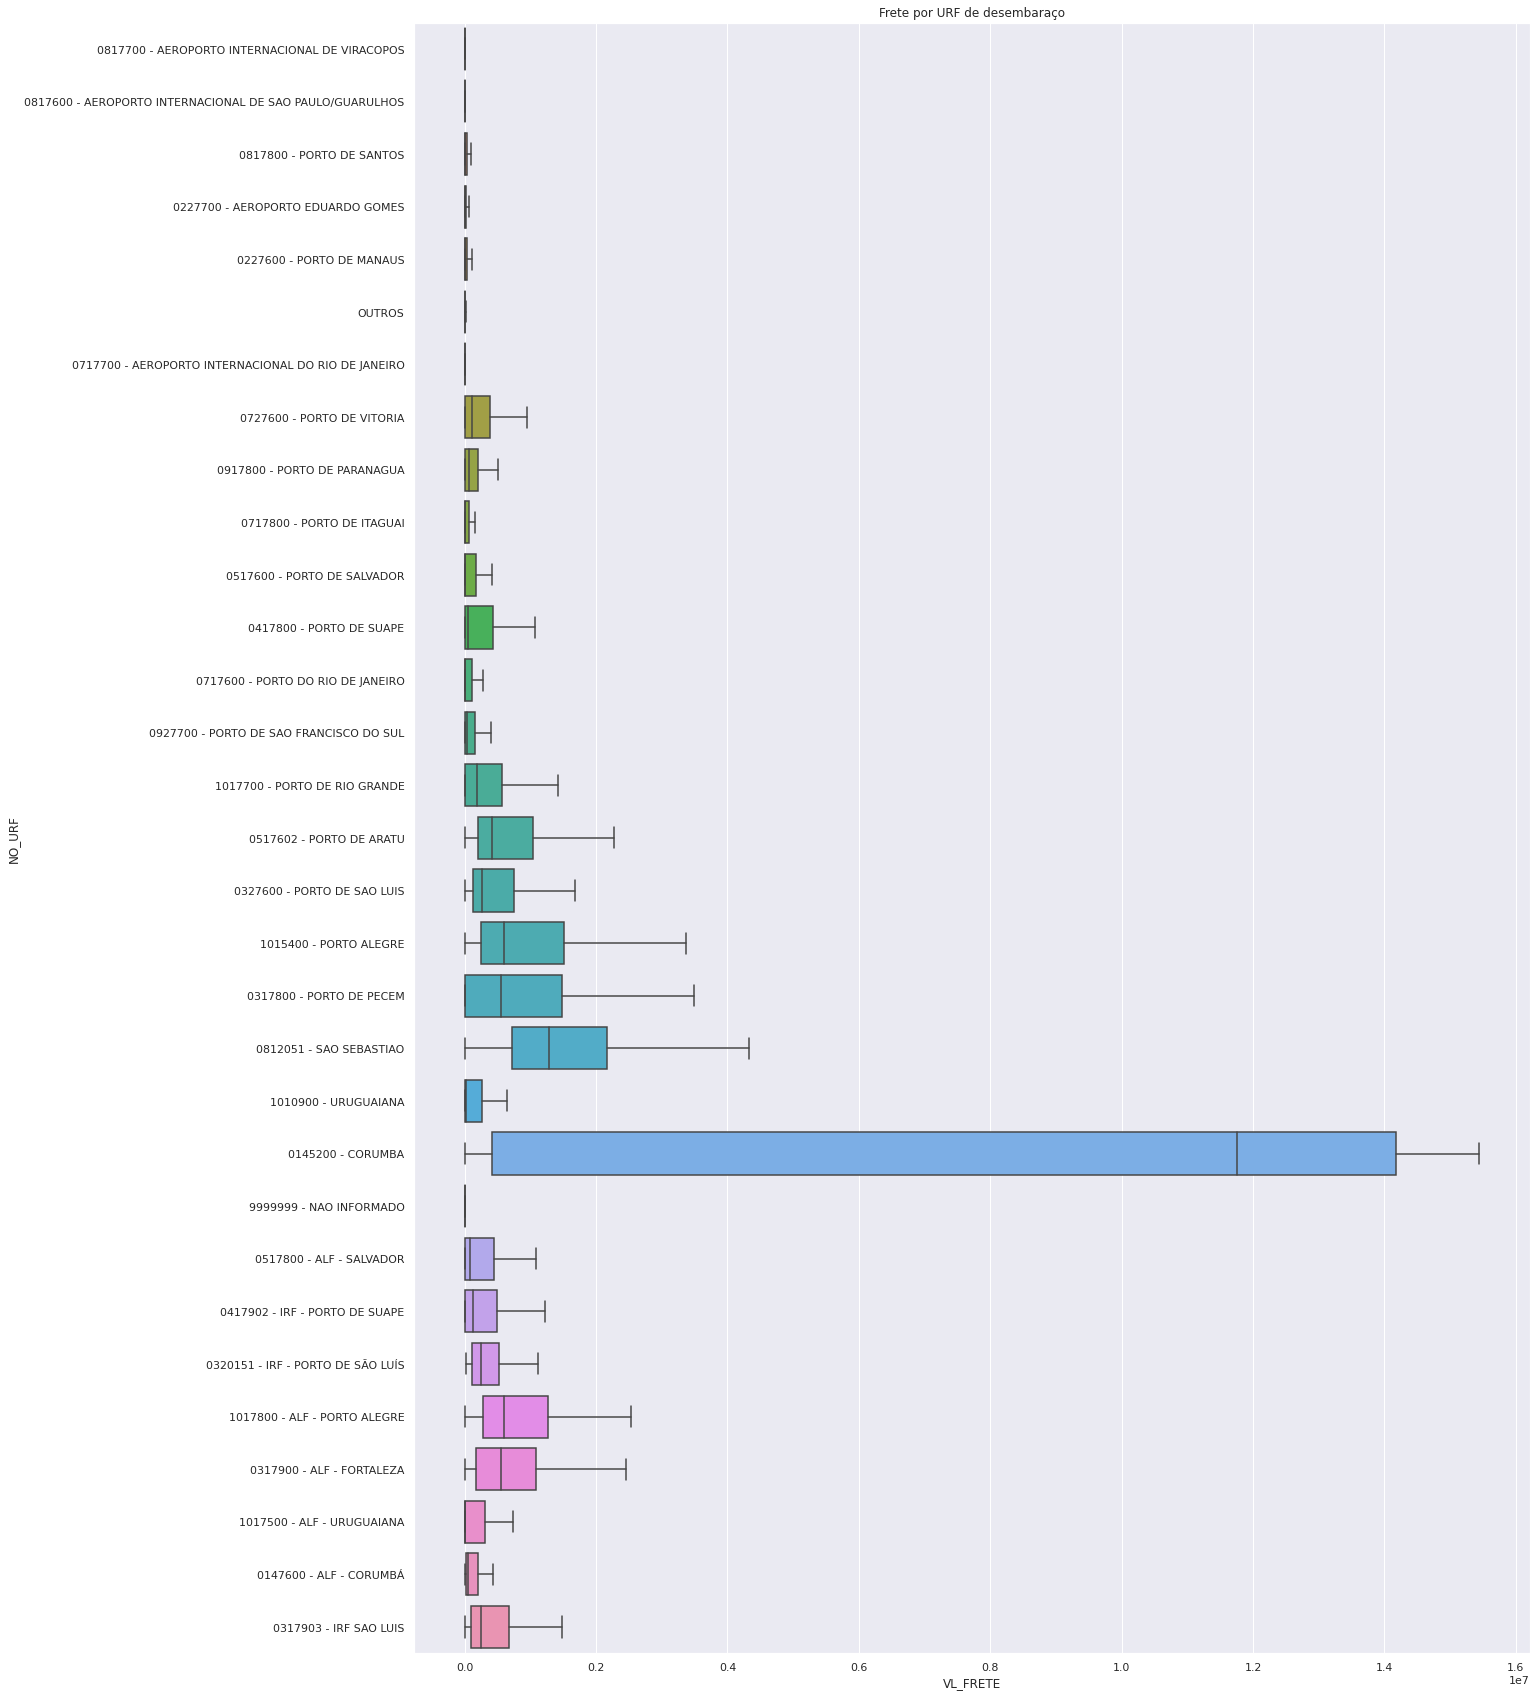

In [355]:
fig, ax2 = plt.subplots(sharey=False, figsize=(20,30))
plt.title("Frete por URF de desembaraço")
sns.boxplot(y='NO_URF', x='VL_FRETE', data=df_total, showfliers = False, ax=ax2)
#plt.xticks(rotation=70)
plt.show()
#plt.savefig('imagens/tipoCE2.png',bbox_inches='tight')

### Análise Variáveis quantitativas


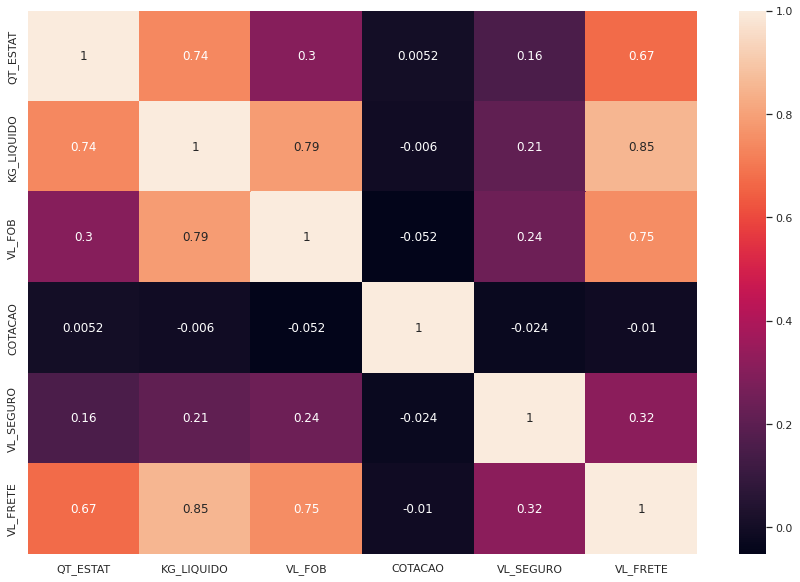

In [ ]:
df_quantitativas = df_total[['QT_ESTAT','KG_LIQUIDO','VL_FOB','COTACAO','VL_SEGURO','VL_FRETE']]

with sns.axes_style("white"):

    f, ax = plt.subplots(figsize=(15, 10))

    ax = sns.heatmap(df_quantitativas.corr(),annot=True)

In [ ]:
df_quantitativas2 = df_total[['KG_LIQUIDO','VL_FOB','VL_FRETE']]
df_quantitativas2

,KG_LIQUIDO,VL_FOB,VL_FRETE
11,5546,282065,50113
545,16,232825,698
546,159,283161,4927
1238,1,1785,57
1239,14863,447108,245502
...,...,...,...
18689495,71211513,25201076,1283000
18689496,10260493,4568995,323036
18689498,363662702,66392477,9774146
18689500,1882,519416,96006


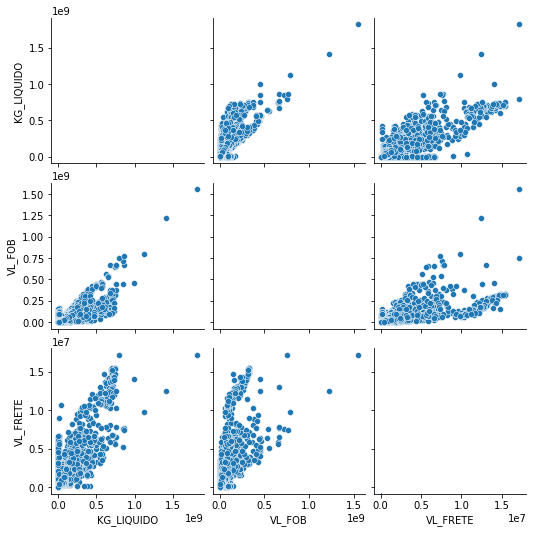

In [ ]:
sns.pairplot(df_quantitativas2, kind = "scatter")
plt.show()

In [ ]:
df_quantmensal = df_total[['CO_ANO','KG_LIQUIDO','VL_FOB','VL_FRETE']]
df_quantmensal = df_quantmensal.groupby(['CO_ANO']).sum()
df_quantmensal.reset_index(inplace=True)
df_quantmensal.head()

,CO_ANO,KG_LIQUIDO,VL_FOB,VL_FRETE
0,2012,54643875431,44422659844,1465987917
1,2013,65147740890,50360622247,1595011857
2,2014,70258813420,49257127564,1629620393
3,2015,64176879008,29416172638,1373484760
4,2016,57038533951,19664440436,1014832747


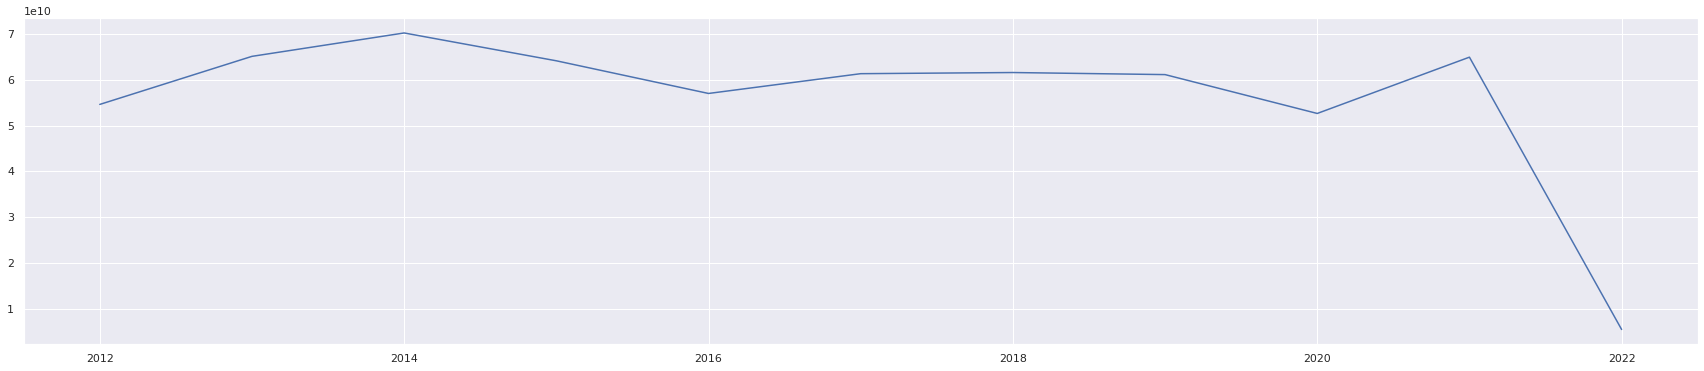

In [ ]:
sns.set_theme(style="darkgrid")

f, ax = plt.subplots(figsize=(30, 6))
plt.plot(df_quantmensal.CO_ANO,df_quantmensal.KG_LIQUIDO)
plt.show()

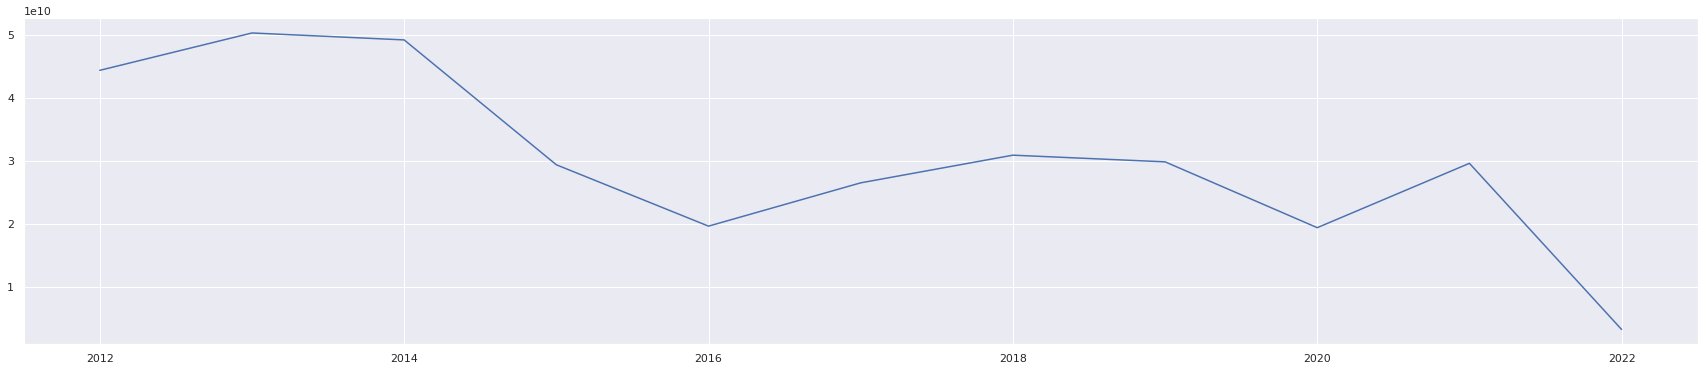

In [ ]:
sns.set_theme(style="darkgrid")

f, ax = plt.subplots(figsize=(30, 6))
plt.plot(df_quantmensal.CO_ANO,df_quantmensal.VL_FOB)
plt.show()

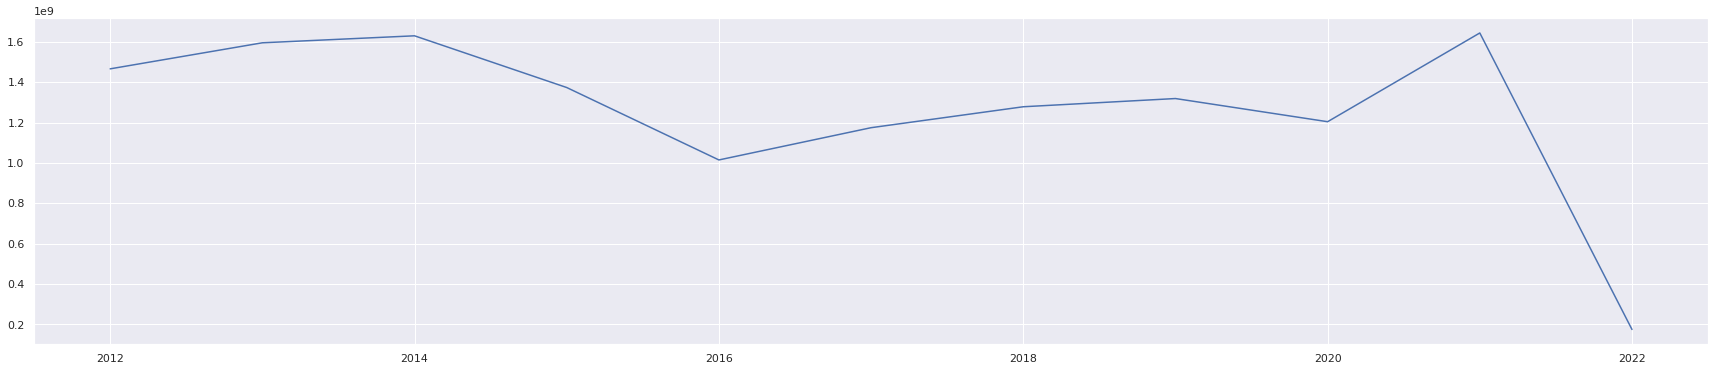

In [ ]:
sns.set_theme(style="darkgrid")

f, ax = plt.subplots(figsize=(30, 6))
plt.plot(df_quantmensal.CO_ANO,df_quantmensal.VL_FRETE)
plt.show()

In [ ]:
df = df_dolar[['ano','COTACAO']]
df

,ano,COTACAO
0,2012,1.788000
1,2012,1.717316
2,2012,1.794045
3,2012,1.856150
4,2012,1.985682
...,...,...
118,2021,5.558900
119,2021,5.658238
120,2022,5.525810
121,2022,5.191053


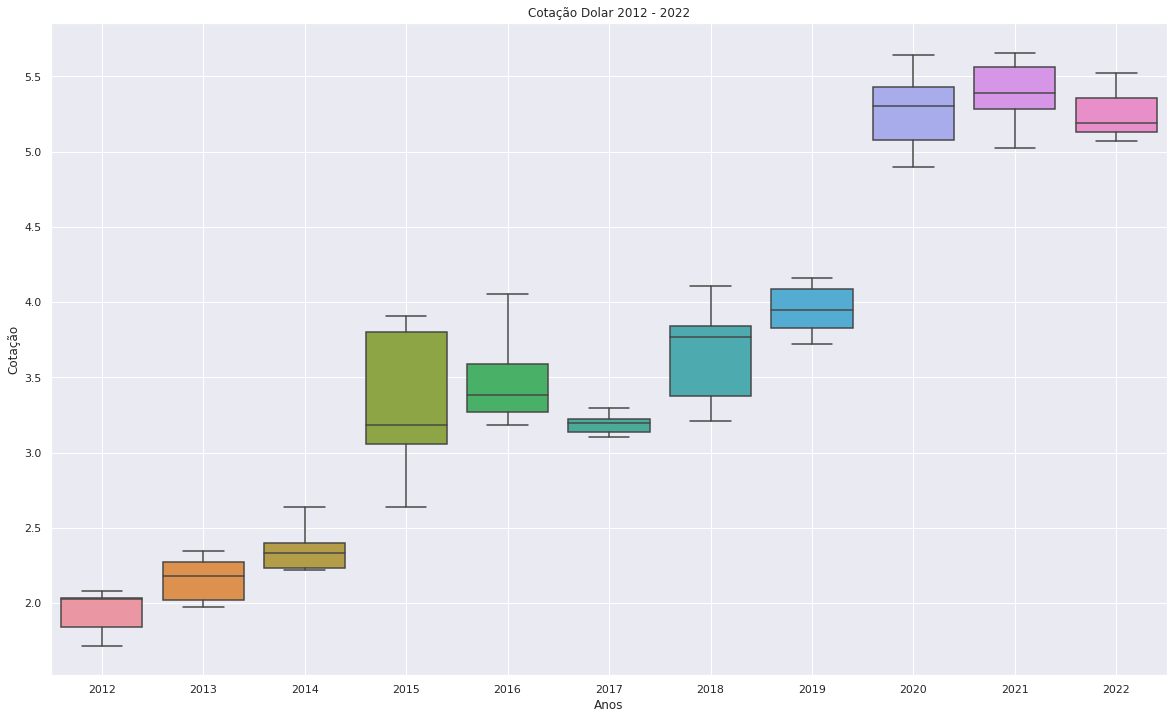

In [ ]:
# Configurando tema
sns.set_theme(style="darkgrid")


# Configurando tamanho da figura
fig, ax = plt.subplots(figsize=(20,12))
ax.set_title("Cotação Dolar 2012 - 2022")
sns.boxplot(x='ano', y='COTACAO', data=df, showfliers = False)
ax.set_ylabel("Cotação")
ax.set_xlabel("Anos")
plt.grid(True)
plt.show()

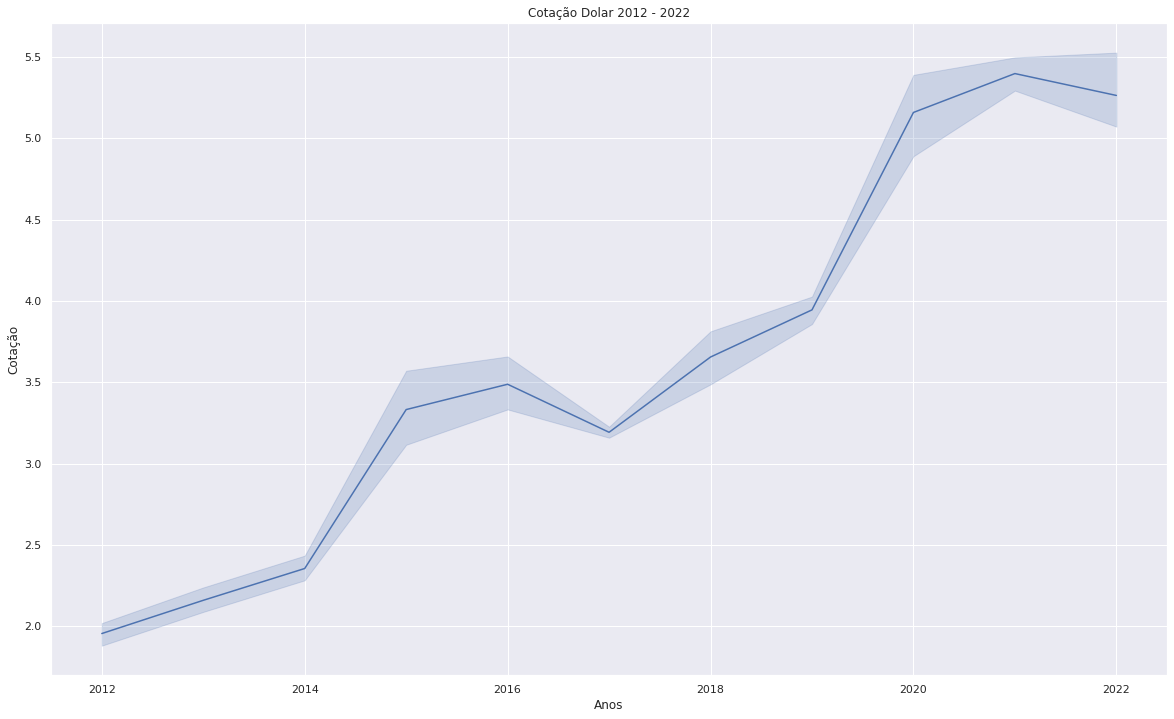

In [ ]:
# Configurando tema
sns.set_theme(style="darkgrid")


# Configurando tamanho da figura
fig, ax = plt.subplots(figsize=(20,12))
ax.set_title("Cotação Dolar 2012 - 2022")
sns.lineplot(x='ano', y='COTACAO', data=df)
ax.set_ylabel("Cotação")
ax.set_xlabel("Anos")
plt.grid(True)
plt.show()


## Modelos de Machine Learning
-----


Separando dados para treino e teste

In [ ]:
df_final = df_total.copy()
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66230 entries, 11 to 18689501
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CO_ANO      66230 non-null  int64  
 1   CO_MES      66230 non-null  int64  
 2   NCM         66230 non-null  object 
 3   NO_PAIS     66230 non-null  object 
 4   SG_UF_NCM   66230 non-null  object 
 5   NO_VIA      66230 non-null  object 
 6   NO_URF      66230 non-null  object 
 7   QT_ESTAT    66230 non-null  int64  
 8   KG_LIQUIDO  66230 non-null  int64  
 9   VL_FOB      66230 non-null  int64  
 10  COTACAO     66230 non-null  float64
 11  FOB_REAIS   66230 non-null  int64  
 12  VL_SEGURO   66230 non-null  int64  
 13  VL_FRETE    66230 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 9.6+ MB


In [ ]:
df_sigla = df_final[['SG_UF_NCM']]
df_sigla = df_sigla.drop_duplicates()
df_sigla.reset_index(inplace=True)
df_sigla.drop(['index'],axis=1,inplace=True)
df_sigla.reset_index(inplace=True)
df_sigla.at[3,'index']=0
df_sigla.at[0,'index']=1
df_sigla.at[1,'index']=2
df_sigla.at[2,'index']=3
df_sigla = df_sigla.sort_values(by='index')
df_sigla = df_sigla.rename(columns={"index":"CO_UF_NCM"})
df_sigla

,CO_UF_NCM,SG_UF_NCM
3,0,OUTROS
0,1,SP
1,2,AM
2,3,RJ
4,4,MG
5,5,ES
6,6,PR
7,7,RS
8,8,PE
9,9,BA


In [ ]:
df_final_sub = df_final.merge(df_pais[['NO_PAIS','CO_PAIS']],on='NO_PAIS', how = 'left').copy()
#df_final_sub["CO_PAIS"] = df_final_sub["CO_PAIS"].replace('NaN',0)
df_final_sub["NCM"] = df_final_sub["NCM"].apply(lambda x: str(x)[:8])
#df_final_sub["NCM"] = df_final_sub["NCM"].replace('OUTROS',0)
df_final_sub = df_final_sub.merge(df_sigla[['SG_UF_NCM','CO_UF_NCM']],on='SG_UF_NCM',how = 'left')
df_final_sub = df_final_sub.merge(df_via[['NO_VIA','CO_VIA']],on='NO_VIA',how = 'left')
#df_final_sub["CO_VIA"] = df_final_sub["CO_VIA"].replace('OUTROS',0)
df_final_sub["NO_URF"] = df_final_sub["NO_URF"].apply(lambda x: str(x)[:7])
df_final_sub["NO_URF"] = df_final_sub["NO_URF"].replace('OUTROS',0)
df_final_sub = df_final_sub[['CO_ANO','CO_MES','NCM','CO_PAIS','CO_UF_NCM','CO_VIA','NO_URF','QT_ESTAT','KG_LIQUIDO','VL_FOB','COTACAO','VL_SEGURO','VL_FRETE']]
df_final_sub.fillna(value = 0,  
          inplace = True)
df_final_sub


,CO_ANO,CO_MES,NCM,CO_PAIS,CO_UF_NCM,CO_VIA,NO_URF,QT_ESTAT,KG_LIQUIDO,VL_FOB,COTACAO,VL_SEGURO,VL_FRETE
0,2012,10,85299020,399.0,1,4.0,0817700,5546,5546,282065,2.029591,640,50113
1,2012,10,85177099,399.0,2,4.0,0817700,250000,16,232825,2.029591,161,698
2,2012,10,85177099,399.0,1,4.0,0817700,334281,159,283161,2.029591,83,4927
3,2012,10,85299020,249.0,3,4.0,0817700,1,1,1785,2.029591,2,57
4,2012,10,85299020,249.0,0,4.0,0817700,14863,14863,447108,2.029591,568,245502
...,...,...,...,...,...,...,...,...,...,...,...,...,...
66225,2017,7,27090010,0.0,7,1.0,1015400,95830,71211513,25201076,3.200524,0,1283000
66226,2017,7,27101921,249.0,3,1.0,0,12021,10260493,4568995,3.200524,0,323036
66227,2017,7,27112100,97.0,11,8.0,0145200,363662702,363662702,66392477,3.200524,0,9774146
66228,2017,7,27112100,97.0,10,8.0,0,1882,1882,519416,3.200524,0,96006


In [ ]:
from sklearn.model_selection import train_test_split

X, y = df_final_sub.drop(['VL_FRETE'],axis=1), df_final_sub.VL_FRETE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

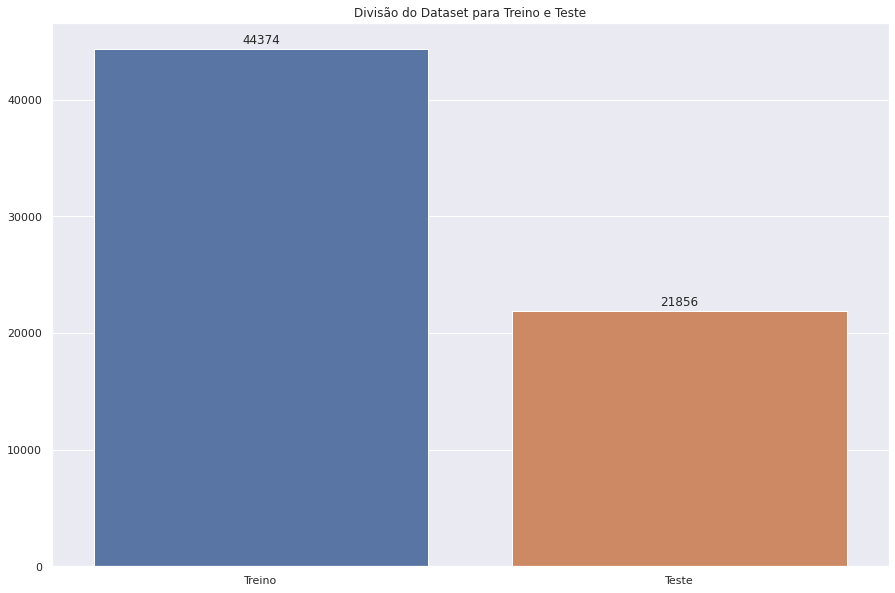

In [ ]:
# Configurando Tema
sns.set_theme(style="darkgrid")

# Configurando tamanho da figura
fig, ax = plt.subplots(figsize=(15,10))
bar = sns.barplot(y=[X_train.shape[0],X_test.shape[0]],x=['Treino','Teste'])

for p in bar.patches:
    bar.annotate(int(p.get_height()), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    
ax.set_title("Divisão do Dataset para Treino e Teste")
plt.show()

## Treinamento

In [ ]:
from sklearn.metrics import mean_squared_error, median_absolute_error,r2_score

In [ ]:
def treinamento_metricas(clf,X_train, X_test, y_train, y_test):
    clf.fit(X_train,y_train)
    predict = clf.predict(X_test)
    r2 = r2_score(y_test, predict)
    mae = median_absolute_error(y_test, predict)

    soma = 0
    regr_y_test = []
    for val in y_test:
        soma += val
        regr_y_test.append(soma)

    soma = 0
    regr_y_predict = []
    for val in clf.predict(X_test):
        soma += val
        regr_y_predict.append(soma)

    # Configurando Tema
    sns.set_theme(style="darkgrid")

    # Configurando grafico
    fig, ax = plt.subplots(figsize=(15,10))

    plt.plot(range(len(regr_y_test)),regr_y_test,label='Gabarito')

    plt.plot(range(len(regr_y_predict)),regr_y_predict,label='Predição')

    ax.set_title('Progressão Aritmética Predição e Gabarito')

    plt.legend()
    plt.show()
    
    return r2,mae

## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
tree = DecisionTreeRegressor()

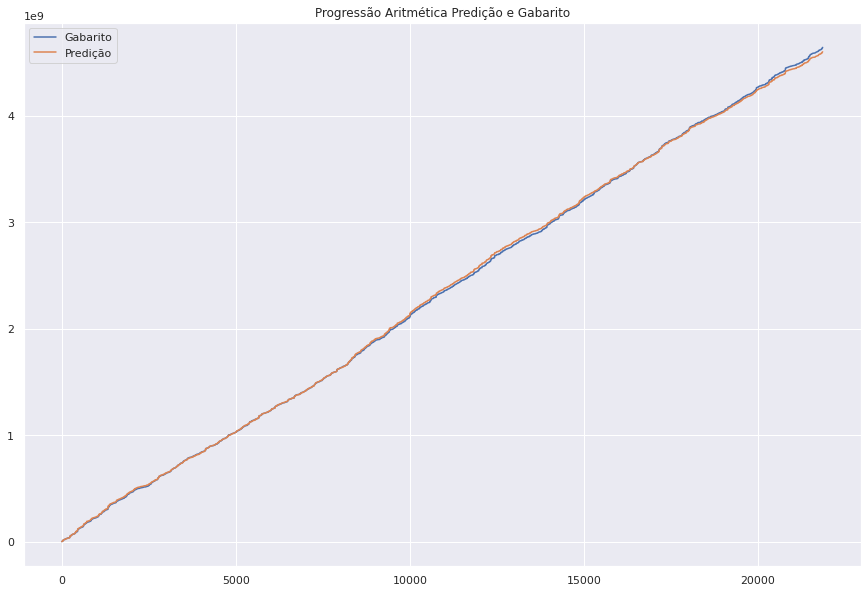

In [ ]:
r2, mae = treinamento_metricas(tree,X_train, X_test, y_train, y_test)

In [ ]:
print(f'\nR2: {r2}\nMAE: {mae}\n')


R2: 0.9001328416910003
MAE: 661.0



## K-Neighbors

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
knn = KNeighborsRegressor()

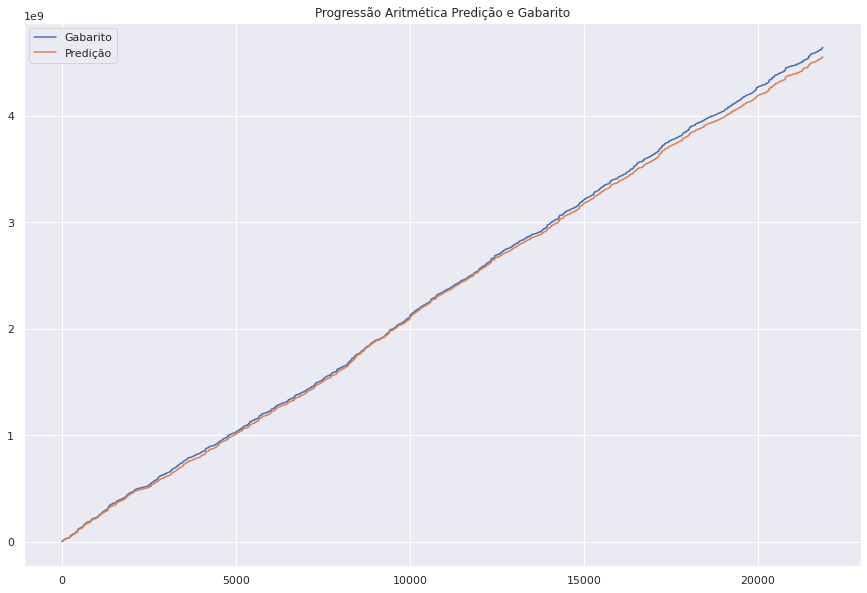

In [ ]:
r2, mae = treinamento_metricas(knn,X_train, X_test, y_train, y_test)

In [ ]:
print(f'\nR2: {r2}\nMAE: {mae}\n')


R2: 0.8673671655188244
MAE: 1252.8000000000002



## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
rfr = RandomForestRegressor(random_state=42)

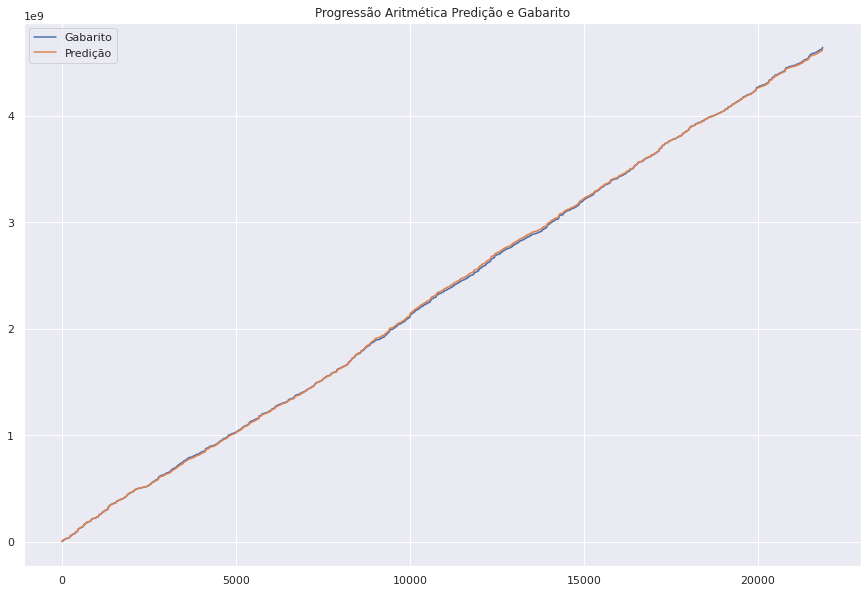

In [ ]:
r2, mae = treinamento_metricas(rfr,X_train, X_test, y_train, y_test)

In [ ]:
print(f'\nR2: {r2}\nMAE: {mae}\n')


R2: 0.949648079647211
MAE: 578.7



### Exportando modelo
-----


In [ ]:
import pickle
with open("model.mod","wb") as outfile:
    pickle.dump(rfr,outfile)

## Importando melhor modelo
-----


In [ ]:
rfr = pickle.load(open("model.mod","rb"))

In [ ]:
print(f"Predicao do modelo: {rfr.predict(X_test)[0]}")
print(f"Valor real: {y_test[0]}")

Predicao do modelo: 218.93


KeyError: ignored

### Restante
-----


In [ ]:
df_importacao = df_importacao[df_importacao.VL_FOB > 0]
df_importacao.info()
df_importacao.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 268821 entries, 17700329 to 36389684
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   CO_ANO      268821 non-null  int64 
 1   CO_MES      268821 non-null  int64 
 2   CO_NCM      268821 non-null  int64 
 3   CO_UNID     268821 non-null  int64 
 4   CO_PAIS     268821 non-null  int64 
 5   SG_UF_NCM   268821 non-null  object
 6   CO_VIA      268821 non-null  int64 
 7   CO_URF      268821 non-null  int64 
 8   QT_ESTAT    268821 non-null  int64 
 9   KG_LIQUIDO  268821 non-null  int64 
 10  VL_FOB      268821 non-null  int64 
 11  VL_FRETE    268821 non-null  int64 
 12  VL_SEGURO   268821 non-null  int64 
dtypes: int64(12), object(1)
memory usage: 28.7+ MB


,CO_ANO,CO_MES,CO_NCM,CO_UNID,CO_PAIS,SG_UF_NCM,CO_VIA,CO_URF,QT_ESTAT,KG_LIQUIDO,VL_FOB,VL_FRETE,VL_SEGURO
17700329,2012,12,85369090,11,249,MG,1,817800,4727460,3036,152808,4743,78
17700358,2012,3,85045000,11,160,AM,1,227600,23941008,25934,973057,20817,1280
17700372,2012,2,31042090,10,149,GO,1,817800,6900000,6900000,3656925,207000,6769
17700456,2012,5,85332120,11,383,SP,4,817700,2336047,86,27603,1143,24
17700526,2012,3,85369040,11,399,RS,4,1017600,97819,163,21980,2450,35


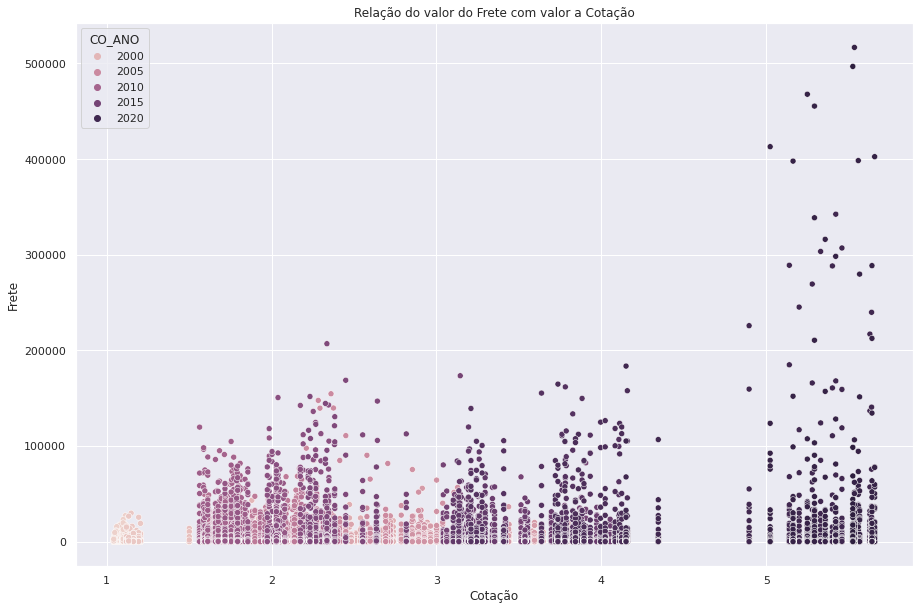

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(data=df_produto,x='COTACAO',y='VL_FRETE',hue='CO_ANO')
ax.set_xlabel('Cotação')
ax.set_ylabel('Frete')

ax.set_title('Relação do valor do Frete com valor a Cotação')

plt.show()

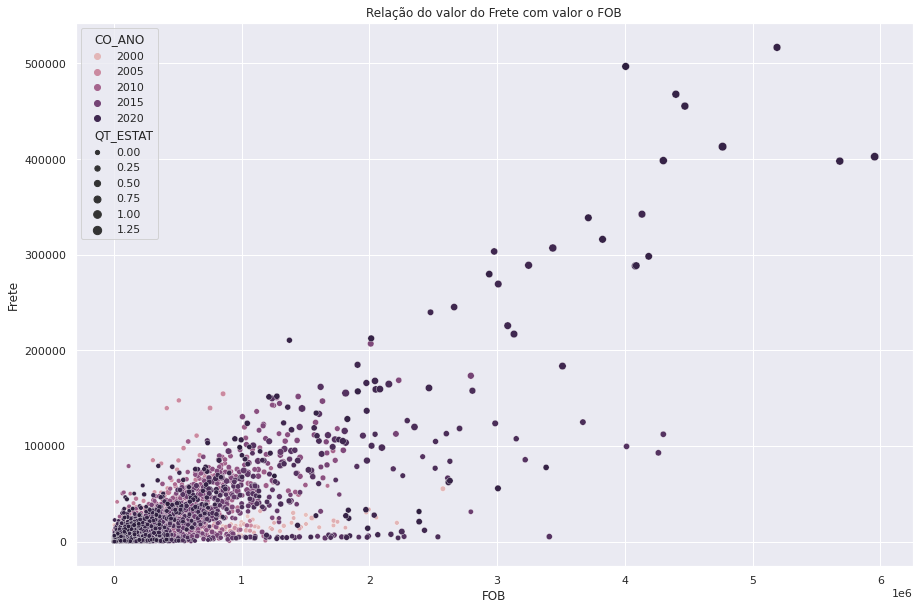

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(data=df_produto,x='VL_FOB',y='VL_FRETE',size='QT_ESTAT',hue='CO_ANO')
ax.set_ylabel('Frete')
ax.set_xlabel('FOB')

ax.set_title('Relação do valor do Frete com valor o FOB')

plt.show()

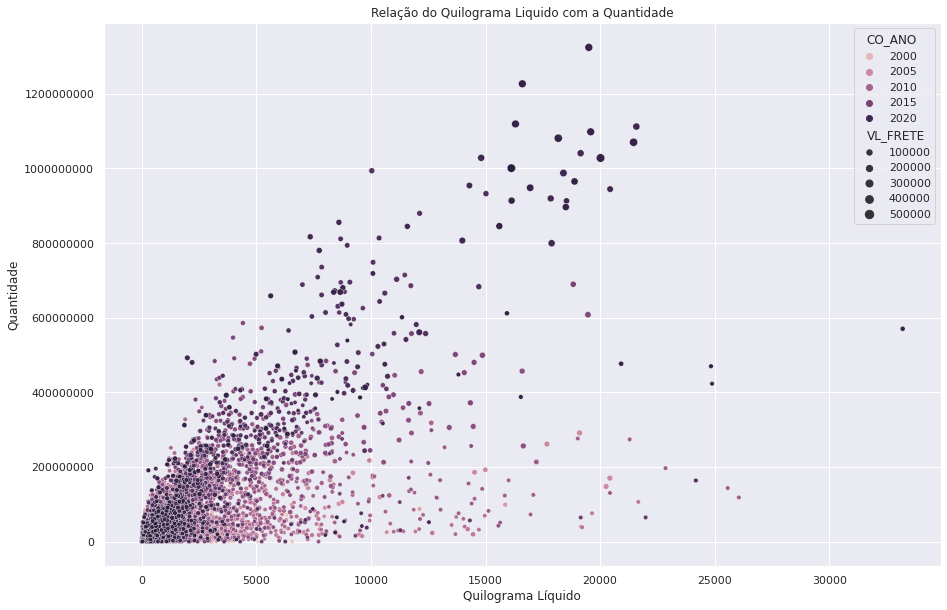

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
g = sns.scatterplot(data=df_produto,x='KG_LIQUIDO',y='QT_ESTAT',size='VL_FRETE',hue='CO_ANO')
ax.set_xlabel('Quilograma Líquido')
ax.set_ylabel('Quantidade')

ax.set_title('Relação do Quilograma Liquido com a Quantidade')

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: int(y)))